In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV, LinearRegression
import os
os.environ['R_HOME'] = r'C:\Program Files\R\R-3.4.1'
os.environ['R_USER'] = r'C:\Users\barry\Anaconda3\Lib\site-packages\rpy2'
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

In [2]:
cwd = os.getcwd()
directory = os.path.join(cwd, 'data')

# Regression analysis of wage determination and approval of H1B cases

## Data source

https://www.foreignlaborcert.doleta.gov/performancedata.cfm#dis

Labor  Condition  Application  ("LCA")  disclosure  data  from  UNITED  STATES  DEPARTMENT  OF  LABOR

We use data from 2008 to 2018.

Variables from 2008:
1. Date
2. Employer Name
3. Location
4. Economic sector
5. Job title
6. Wage
7. Citizenship

Variables added after 2015:
1. Total number of employee
2. Firm's founding year
3. Education level
4. University
5. Major
6. Prior working experience

### Preprocessing

In [3]:
dataPre2015 = pd.DataFrame()
feature = pd.DataFrame(columns = range(2008,2015))
for year in range(2008,2015):
    data_temp = pd.read_excel(os.path.join(directory,'PERM_FY'+str(year) + '.xlsx'))
    data_temp['Year'] = year
    dataPre2015 = dataPre2015.append(data_temp, sort = False)
    feature[year] = pd.Series(data_temp.columns)

In [4]:
Feature_name = ['Case No','Employer','NAICS Code','Sector','Job title','Job level','Wage','Unit of pay','City','State','Citizenship','Class of admission','Year']
feature_num = [0,4,10,12,15,16,18,19,23,24,25,26,27]

In [5]:
#feature.to_excel('temp.xlsx')
feature = pd.read_excel('temp.xlsx')

In [6]:
dataPre2015_use = pd.DataFrame(columns = Feature_name)
for year in range(2008,2015):
    data_temp = dataPre2015[dataPre2015['Year'] == year][feature[year][feature_num].values]
    data_temp.columns = Feature_name
    dataPre2015_use = dataPre2015_use.append(data_temp, sort = False)

In [7]:
code2sector = dataPre2015_use.dropna()[['NAICS Code','Sector']].set_index('NAICS Code').to_dict()

In [8]:
dataPost2015 = pd.DataFrame()
feature = pd.DataFrame(columns = range(2015,2018))
for year in range(2015,2018):
    data_temp = pd.read_excel(os.path.join(directory,'PERM_FY'+str(year) + '.xlsx'))
    data_temp['Year'] = year
    dataPost2015 = dataPost2015.append(data_temp, sort = False)
    feature[year] = pd.Series(data_temp.columns)

In [9]:
def f(x,code2sector):
    try:
        return code2sector['Sector'][x]
    except KeyError:
        return None

In [10]:
dataPost2015_1 = dataPost2015[['CASE_NUMBER','EMPLOYER_NAME','NAICS_US_CODE','JOB_INFO_JOB_TITLE','PW_LEVEL_9089','PW_AMOUNT_9089','WAGE_OFFER_UNIT_OF_PAY_9089','JOB_INFO_WORK_CITY','JOB_INFO_WORK_STATE','COUNTRY_OF_CITIZENSHIP','CLASS_OF_ADMISSION','Year']]
dataPost2015_1.columns = ['Case No','Employer','NAICS Code','Job title','Job level','Wage','Unit of pay','City','State','Citizenship','Class of admission','Year']
dataPost2015_1['Sector'] = dataPost2015_1['NAICS Code'].apply(lambda x: f(x, code2sector))

C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
dataPre2015_use = dataPre2015_use.dropna()
dataPost2015_1 = dataPost2015_1.dropna()
dataset1 = dataPre2015_use.append(dataPost2015_1, sort = False)

In [12]:
dataset1['Wage'] = dataset1['Wage'].astype('float')
year = ['YR','yr','Year']
month = ['MTH','mth','Month']
week = ['WK','wk','Week']
biweek = ['BI','bi','Bi-Weekly']
hour = ['HR','hr','Hour']
monthpay = dataset1['Unit of pay'].apply(lambda x: x in month)
dataset1['Wage'] = dataset1['Wage']*dataset1['Wage'].apply(lambda x: x < 100)*250*8 \
   + dataset1['Wage']*dataset1['Wage'].apply(lambda x: x > 100 and x < 1000)*50 \
    + dataset1['Wage']*dataset1['Wage'].apply(lambda x: x > 1000 and x < 20000)*12 \
    + dataset1['Wage']*dataset1['Wage'].apply(lambda x: x > 20000)

In [13]:
dataset1 = dataset1[dataset1["Wage"] > 10000]
dataset1['Job level'] = dataset1['Job level'].str.upper()
dataset1['Sector'] = dataset1['Sector'].str.capitalize()
statemap = pd.read_excel('statemap.xlsx')
dataset1['State'] = dataset1['State'].replace(statemap['code'].values, statemap['state'].values)
dataset1['State'] = dataset1['State'].str.capitalize()

In [14]:
def g(x,year, month, week, hour,biweek):
    if x in year:
        return 'YR'
    elif x in month:
        return 'MTH'
    elif x in week:
        return 'WK'
    elif x in hour:
        return 'HR'
    else:
        return 'BiWK'

In [15]:
dataset1['Unit of pay'] = dataset1['Unit of pay'].apply(lambda x: g(x,year, month, week, hour, biweek))
dataset1 = dataset1[dataset1['Class of admission'] == 'H-1B']

In [16]:
dataset1_X = dataset1.set_index('Case No').drop(['Wage'],axis = 1)
dataset1_X = dataset1_X.reset_index()
dataset1_y = dataset1.set_index('Case No')['Wage']
dataset1_y = dataset1_y.reset_index()

### Exploratory data analysis

<IPython.core.display.Javascript object>


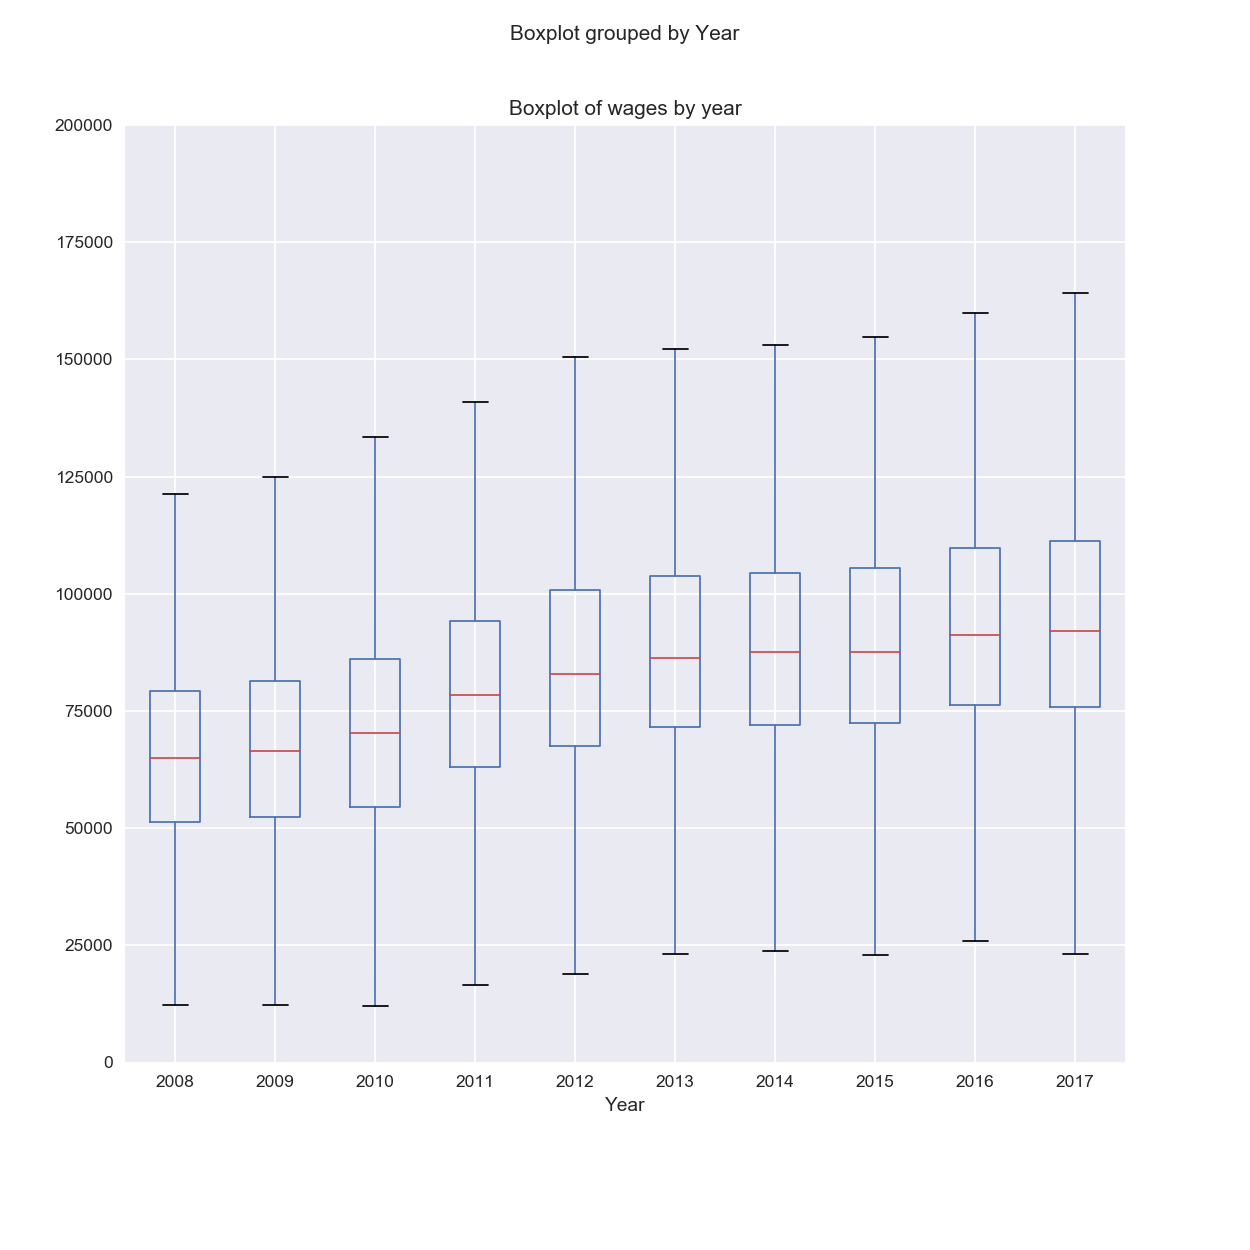

In [19]:
# dataset1.boxplot('Wage','Year',figsize=(10,10))
# plt.ylim(0, 200000)
# plt.title('Boxplot of wages by year')
# plt.show()


<IPython.core.display.Javascript object>


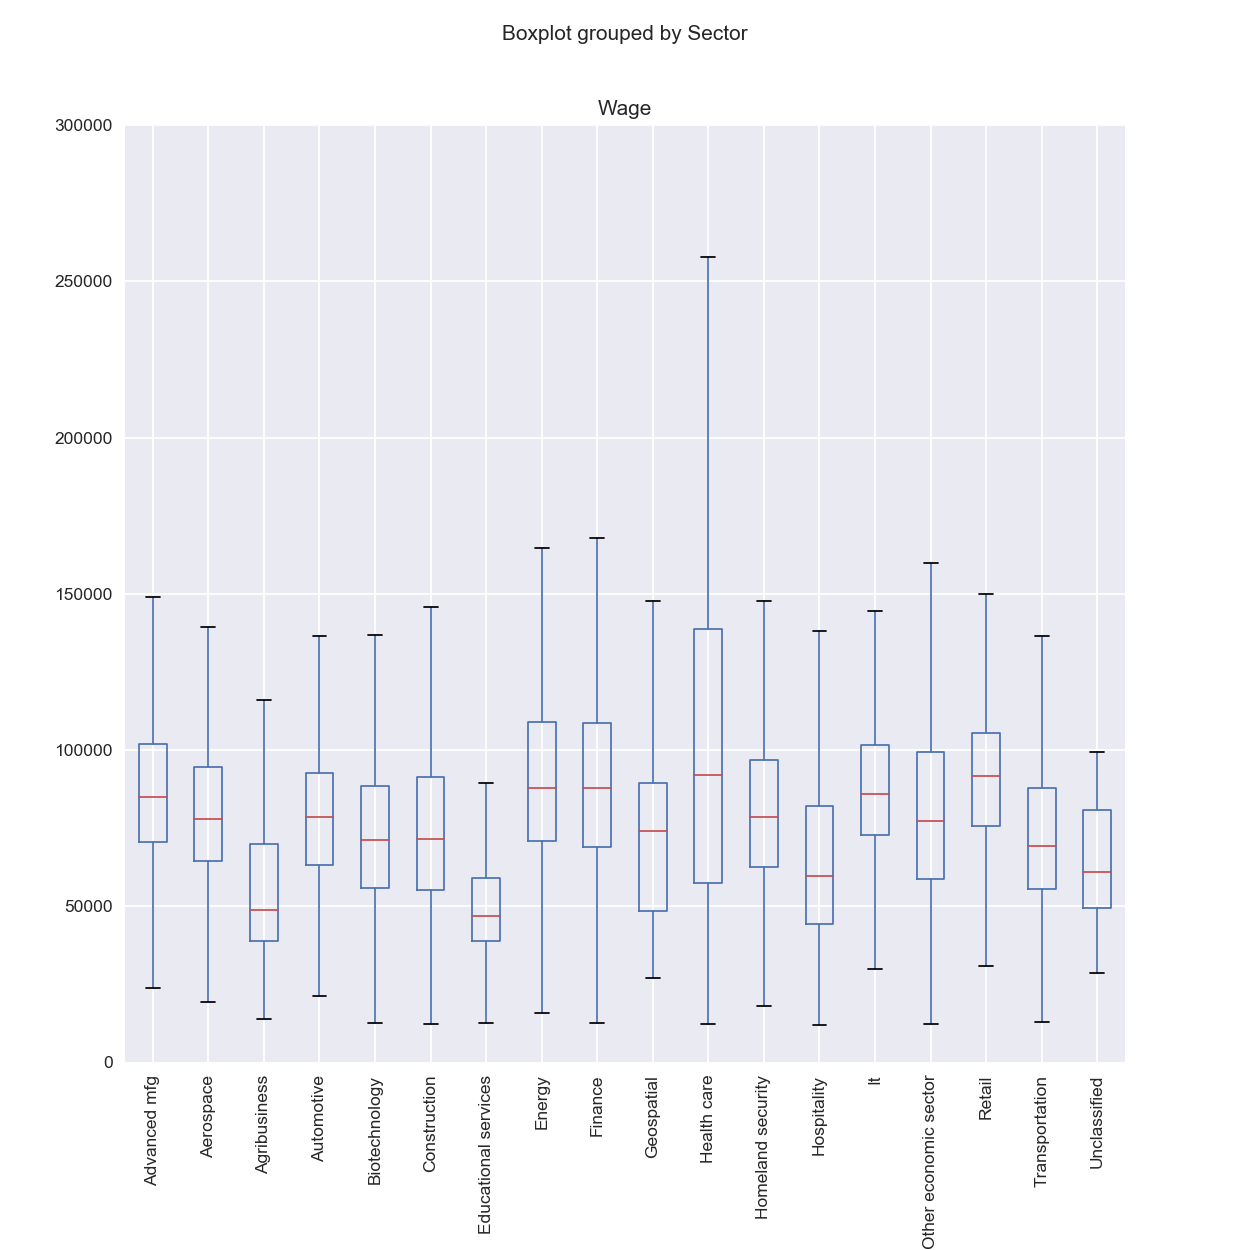

In [21]:
dataset1.boxplot('Wage','Sector', figsize = (10,10))
plt.ylim(0, 300000)
plt.xticks(rotation = 90)
plt.show()

<IPython.core.display.Javascript object>


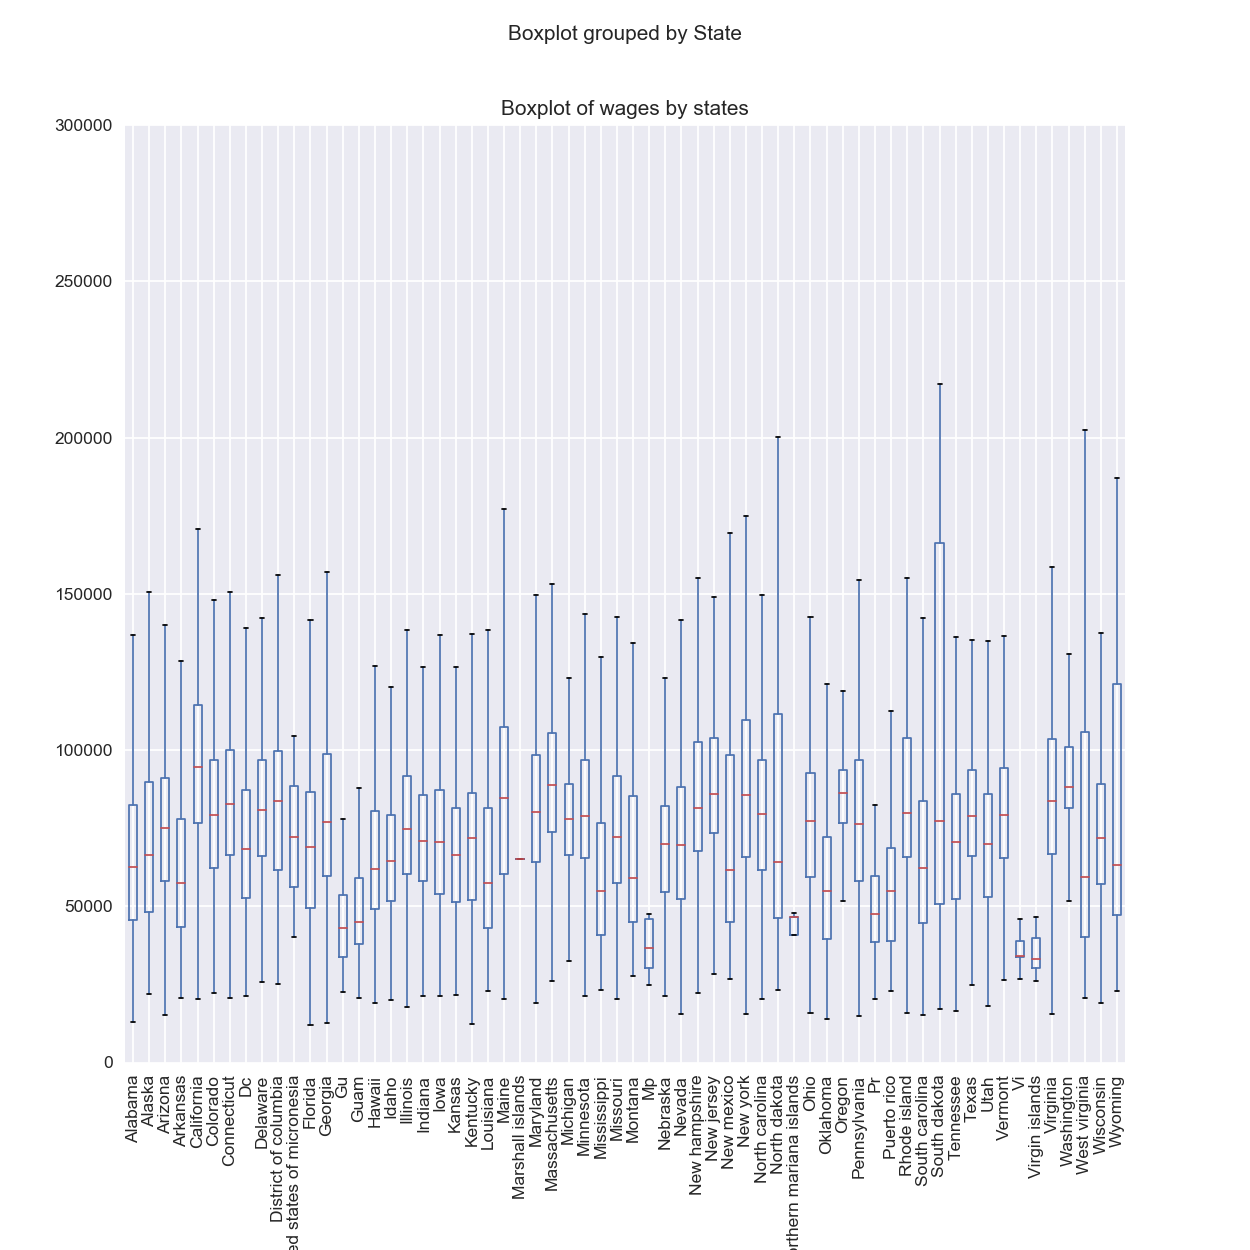

In [22]:
dataset1.boxplot('Wage','State', figsize = (10,10))
plt.ylim(0, 300000)
plt.title('Boxplot of wages by states')
plt.xticks(rotation = 90)
plt.show()

<IPython.core.display.Javascript object>


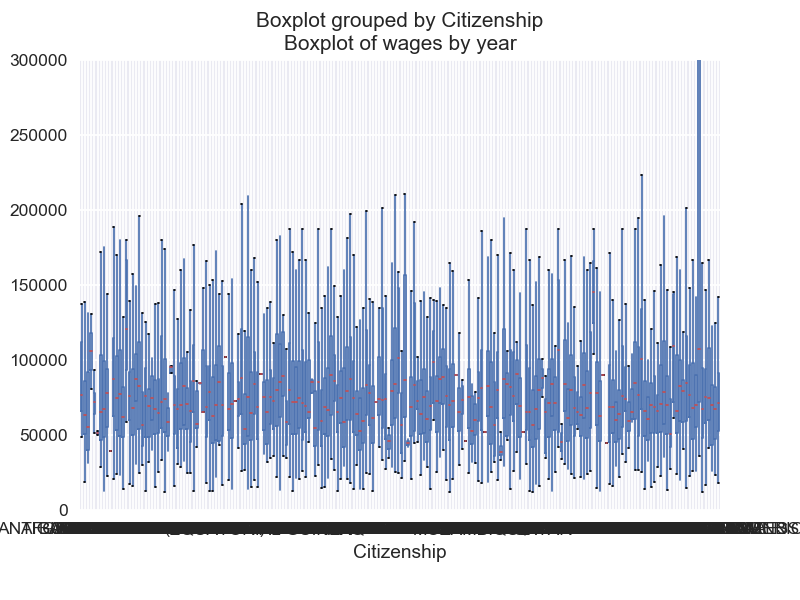

In [17]:
#np.exp(dataset1_y[dataset1_onehot['Citizenship_' + dataset1['Citizenship'].value_counts()[:10].index].sum(axis = 1) != 0]

dataset1.boxplot('Wage','Citizenship')
plt.ylim(0, 300000)
plt.title('Boxplot of wages by year')
plt.show()

<IPython.core.display.Javascript object>


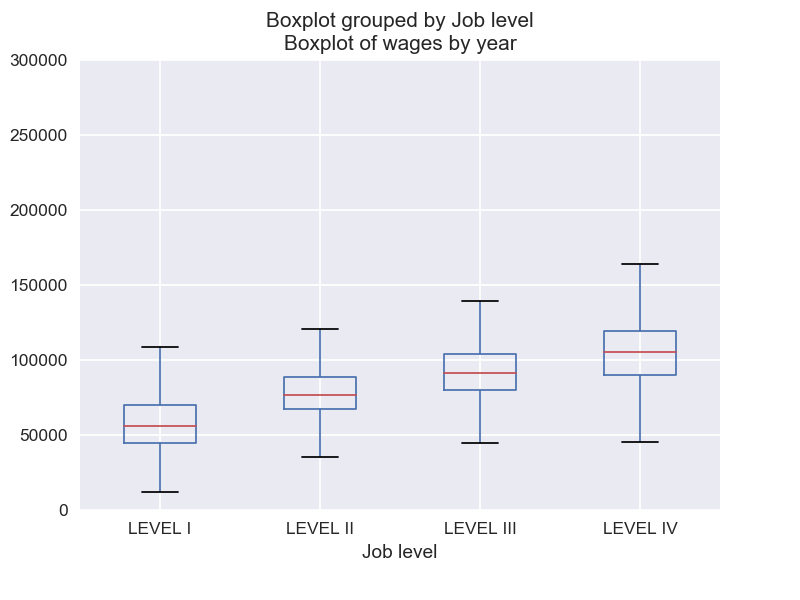

In [24]:
dataset1.boxplot('Wage','Job level')
plt.ylim(0, 300000)
plt.title('Boxplot of wages by year')
plt.show()

<IPython.core.display.Javascript object>


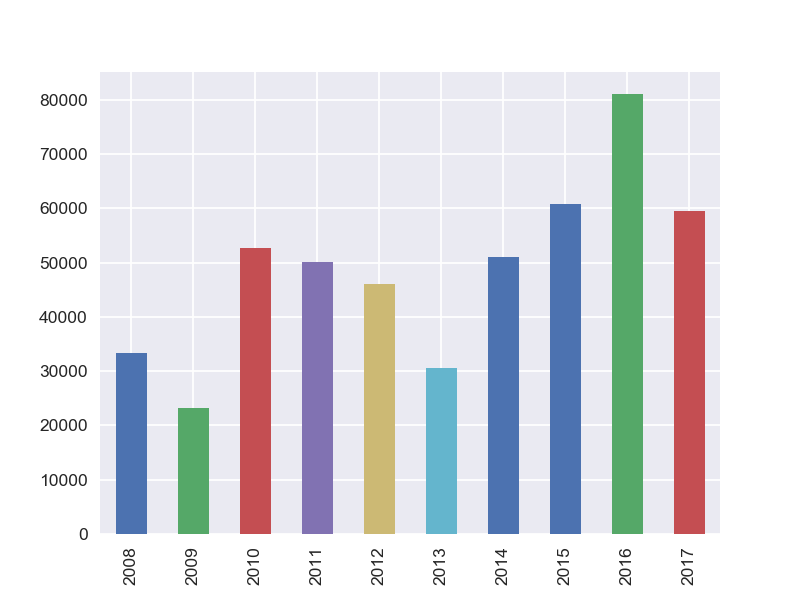

In [25]:
dataset1['Year'].value_counts().sort_index().plot(kind = 'bar')

<IPython.core.display.Javascript object>


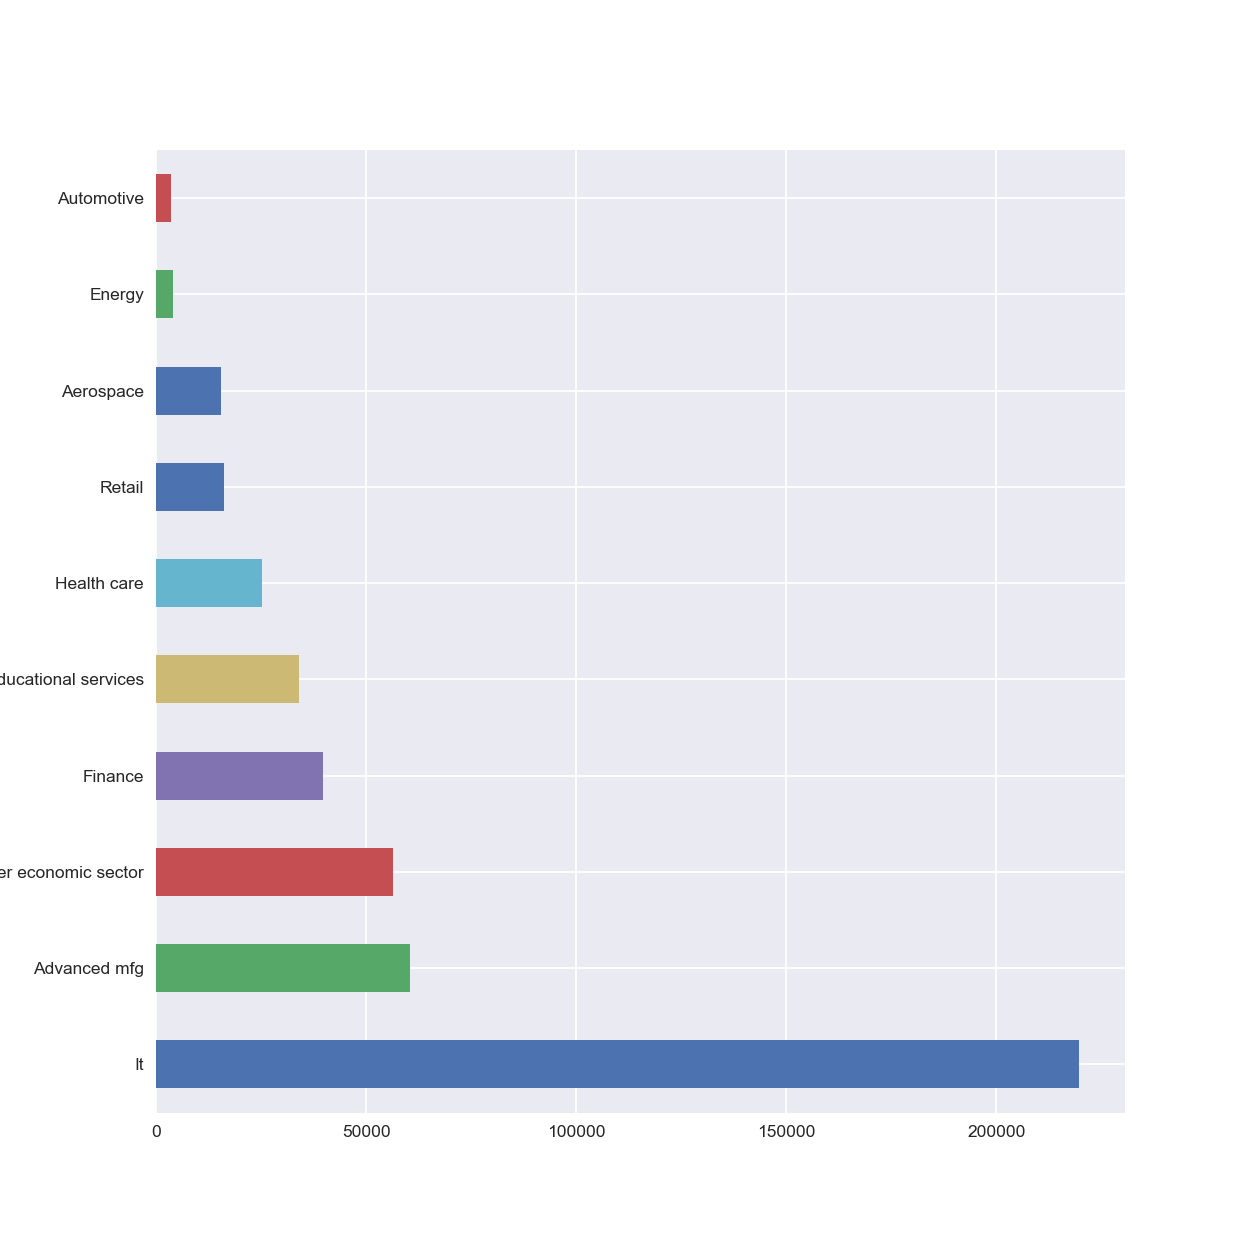

In [37]:
dataset1['Sector'].value_counts()[:10].plot(kind ='barh', figsize = (10,10))

<IPython.core.display.Javascript object>


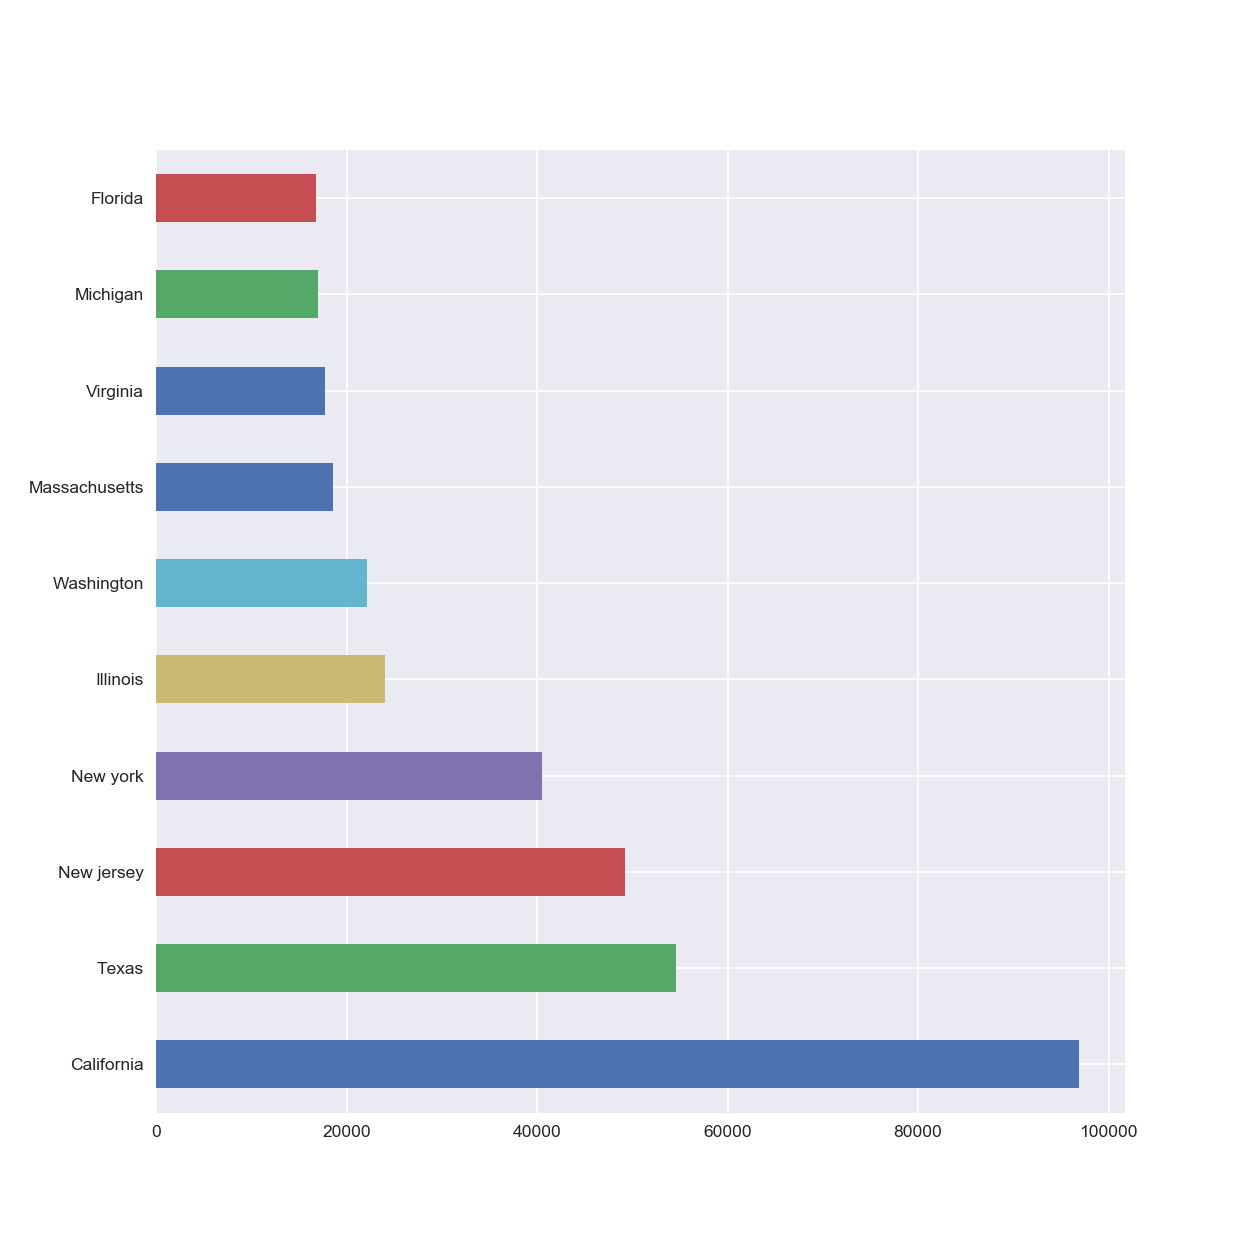

In [36]:
dataset1['State'].value_counts()[:10].plot(kind ='barh', figsize = (10,10))

<IPython.core.display.Javascript object>


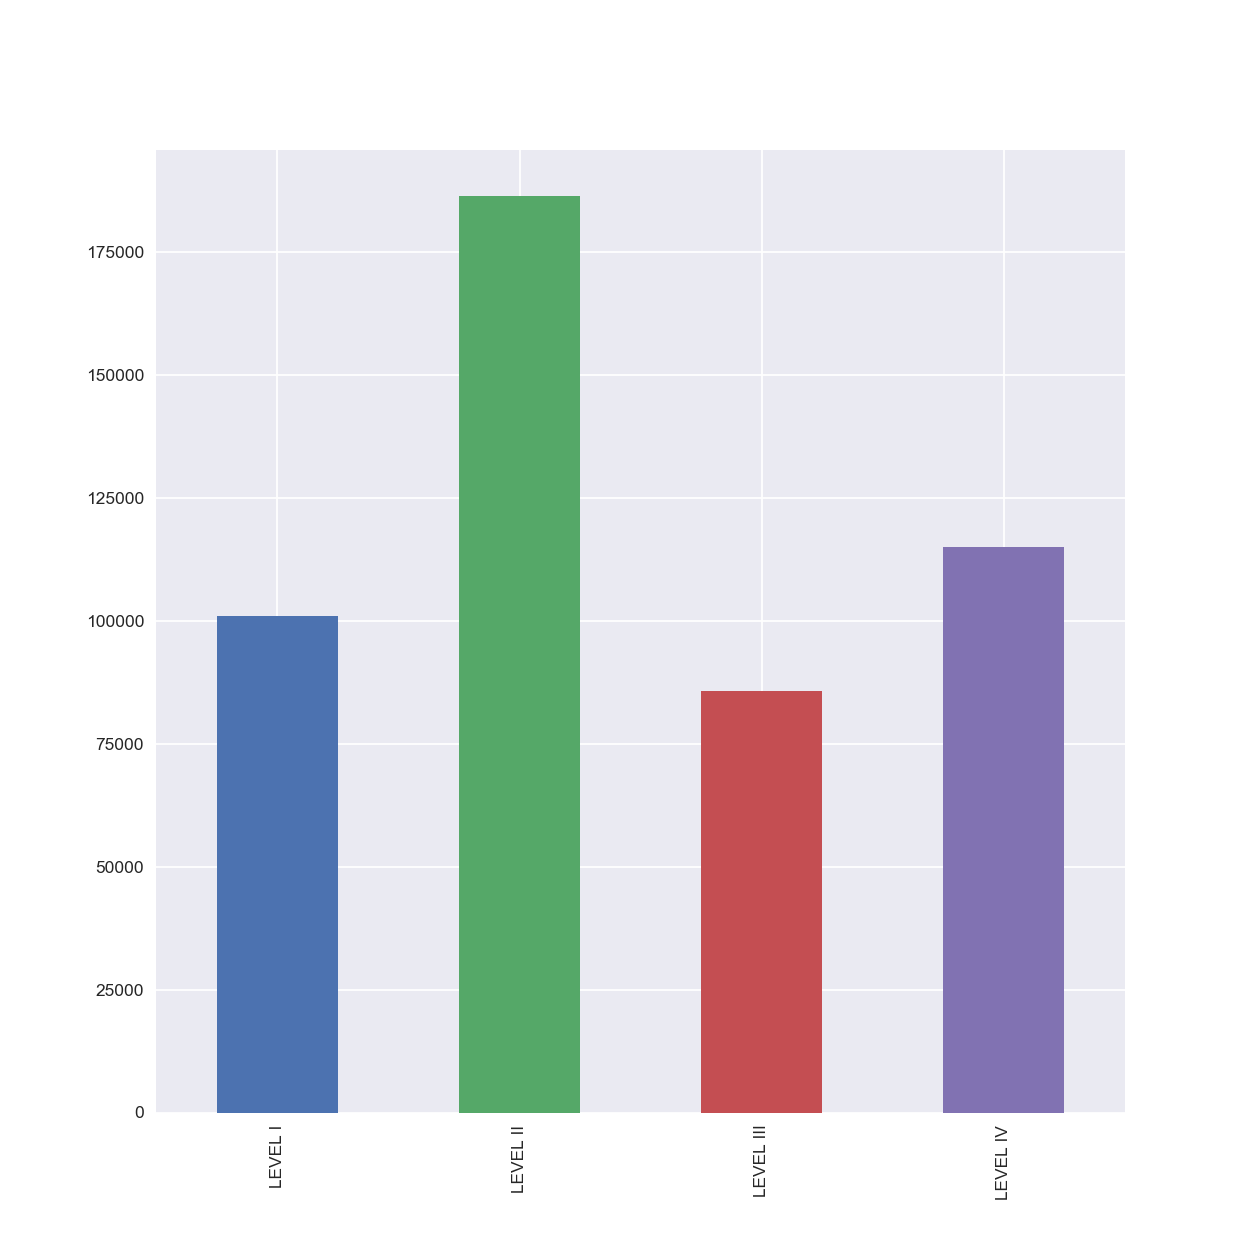

In [28]:
dataset1['Job level'].value_counts()[:20].sort_index().plot(kind ='bar', figsize = (10,10))

In [28]:
dataset1['Employer'].value_counts()[:20]

COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION    16480
MICROSOFT CORPORATION                            11623
GOOGLE INC.                                       4580
INTEL CORPORATION                                 4578
AMAZON CORPORATE LLC                              3824
APPLE INC.                                        2890
ORACLE AMERICA, INC.                              2221
DELOITTE CONSULTING LLP                           1955
HCL AMERICA INC.                                  1929
QUALCOMM TECHNOLOGIES INC.                        1826
CISCO SYSTEMS, INC.                               1822
INFOSYS LTD.                                      1749
QUALCOMM, INC.                                    1629
IBM CORPORATION                                   1613
JP MORGAN CHASE & CO                              1592
BLOOMBERG L.P.                                    1490
ERNST & YOUNG U.S. LLP                            1419
PRICEWATERHOUSECOOPERS                            1289
CUMMINS IN

In [19]:
group = dataset1.groupby('Year')
panel = pd.DataFrame(index = range(2008,2018),columns = dataset1['Sector'].unique())
for year in range(2008,2018):
    panel.loc[year] = group.get_group(year)['Sector'].value_counts()

<IPython.core.display.Javascript object>


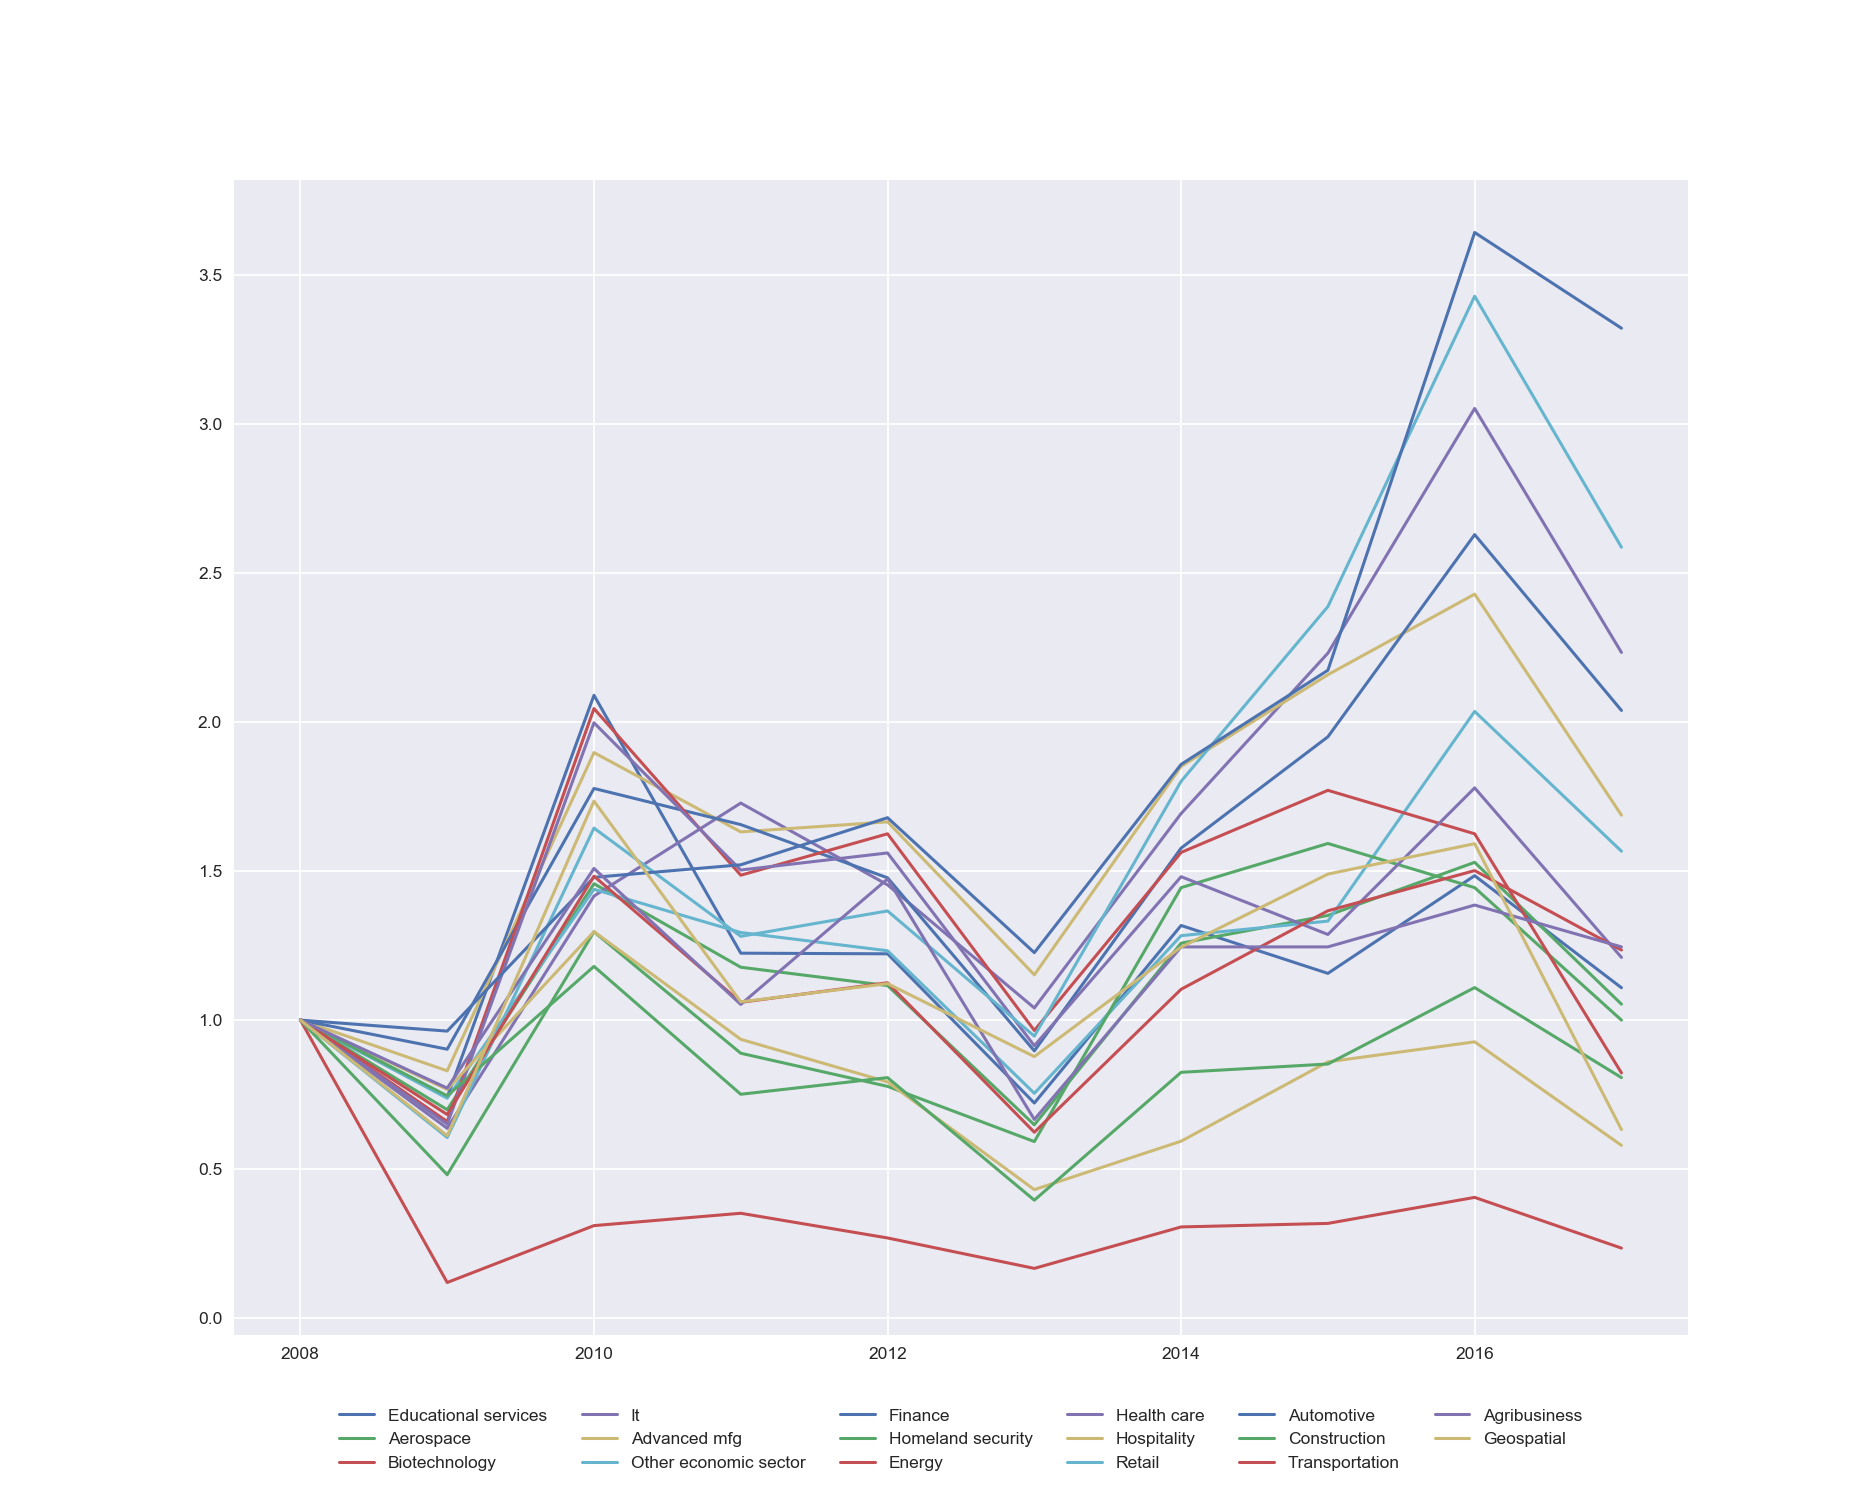

In [32]:
fig = plt.figure(figsize = (15,12))
ax = plt.subplot(111)
(panel.dropna(axis = 1)/panel.dropna(axis = 1).loc[2008]).plot(ax = ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=6)

In [31]:
(panel.dropna(axis = 1)/panel.dropna(axis = 1).loc[2009])

Educational services Aerospace Biotechnology       It Advanced mfg  \
2008              1.34816   1.42977       8.34568  1.56968      1.20481   
2009                    1         1             1        1            1   
2010              2.81731   2.08386       2.59259  2.22299      2.28609   
2011              1.65088   1.68344       2.93827  2.71257      1.96554   
2012              1.64802   1.59539       2.24691  2.28189      2.00618   
2013             0.973219  0.927673       1.39506  1.63376      1.38784   
2014              1.77618   1.79874       2.55556  2.65732      2.23017   
2015              1.55954   1.93187       2.65432  3.50194      2.60078   
2016              2.00143   2.18658       3.38272  4.79043      2.92653   
2017               1.4945   1.50629       1.96296  3.50548      2.03316   

     Other economic sector   Finance Homeland security   Energy Health care  \
2008               1.35488    1.1082           2.07692  1.51579     1.53589   
2009                     1         1                 1        1           1   
2010               1.94939    1.9694           2.69231      3.1      3.0677   
2011               1.75305   1.83503           1.84615  2.25263     2.30914   
2012               1.67012   1.63725           1.61538  2.46316     2.39723   
2013               1.02226  0.993792           1.23077  1.46316     1.40375   
2014               1.73872   1.74767                 3  2.36842     2.27488   
2015               1.80488   2.16142           3.30769  2.68421     1.97716   
2016               2.75793   2.91308                 3  2.46316     2.73246   
2017               2.12256   2.25942           2.07692  1.24737     1.85889   

     Hospitality   Retail Automotive Construction Transportation Agribusiness  \
2008     1.30292  1.64931    1.03825      1.34014         1.4633      1.29545   
2009           1        1          1            1              1            1   
2010     1.68978  2.71181    1.53552      1.58163        2.16972      1.95455   
2011     1.21898  2.11285    1.57923       1.0068        1.55046      1.36364   
2012     1.03285  2.25347    1.74317      1.08163        1.64679      1.90909   
2013    0.562044  1.56076    1.27322     0.530612       0.912844     0.863636   
2014    0.773723  2.97049    1.92896      1.10544        1.61468      1.61364   
2015     1.12044   3.9375    2.25683      1.14286              2      1.61364   
2016     1.20803  5.65451    3.78142      1.48639        2.19725      1.79545   
2017    0.755474  4.26562    3.44809      1.08163        1.80734      1.61364   

     Geospatial  
2008    1.63333  
2009          1  
2010    2.83333  
2011    1.73333  
2012    1.83333  
2013    1.43333  
2014    2.03333  
2015    2.43333  
2016        2.6  
2017    1.03333

In [32]:
sector = panel.dropna(axis = 1).columns

<IPython.core.display.Javascript object>


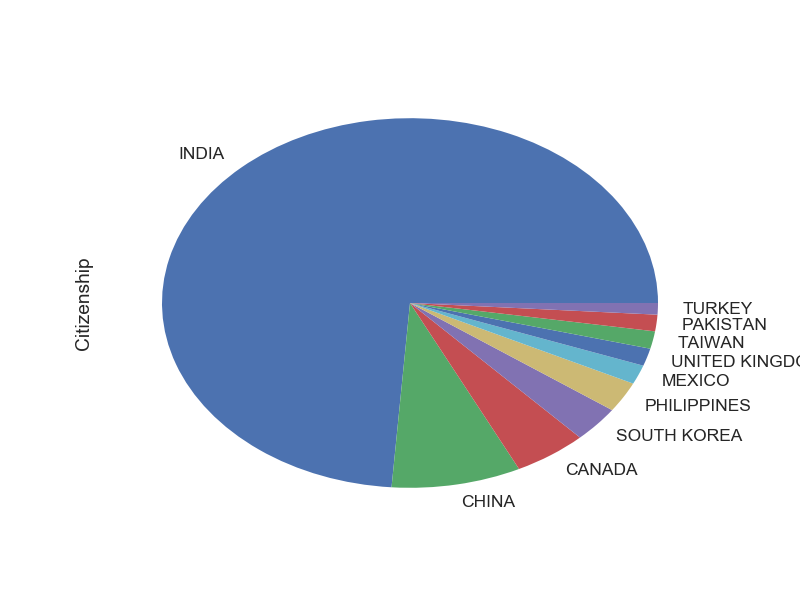

In [70]:
dataset1['Citizenship'].value_counts()[:10].plot(kind = 'pie')

In [33]:
dataset1.columns

Index(['Case No', 'Employer', 'NAICS Code', 'Sector', 'Job title', 'Job level',
       'Wage', 'Unit of pay', 'City', 'State', 'Citizenship',
       'Class of admission', 'Year'],
      dtype='object')

## Model prediction: Linear regression with L1 Penalty (Lasso)


We use one-hot mapping for categorical data. Focus on the top 20 categories in each feature

We trained two models: Model1 using data from 2008 to 2018 with fewer features, and Model2 using data from 2015 to 2018



In [121]:
top20 = dict.fromkeys(['Sector','Job level','Unit of pay','State','Citizenship','Class of admission','Year'])
for category in top20.keys():
    top20[category] = dataset1_X[category].value_counts()[:20].index
top20.keys()

dict_keys(['Sector', 'Job level', 'Unit of pay', 'State', 'Citizenship', 'Class of admission', 'Year'])

In [122]:
dataset1_onehot = dataset1_X[list(top20.keys())].copy()
for category in top20.keys():
    dataset1_onehot = dataset1_onehot[dataset1_onehot[category].apply(lambda x: x in top20[category])]
dataset1_onehot = pd.get_dummies(dataset1_onehot, columns=dataset1_onehot.columns,prefix =dataset1_onehot.columns)
print('Original sample size: ' + str(len(dataset1_X.index)))
print('Sample size after selection: ' + str(len(dataset1_onehot.index)))

Original sample size: 488205
Sample size after selection: 393926


In [123]:
dataset1_y = dataset1_y['Wage'].loc[dataset1_onehot.index]
dataset1_y = np.log(dataset1_y)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(dataset1_onehot, dataset1_y, random_state=0)

In [125]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.logspace(-9, 0, 10)}

Fitting model1 using 10-fold Cross-validation

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.logspace(-9, 0, 10)}
grid = GridSearchCV(Lasso(max_iter=100, tol = 0.001), param_grid, cv=10, return_train_score=True, iid=False)
grid.fit(X_train, y_train)

<IPython.core.display.Javascript object>


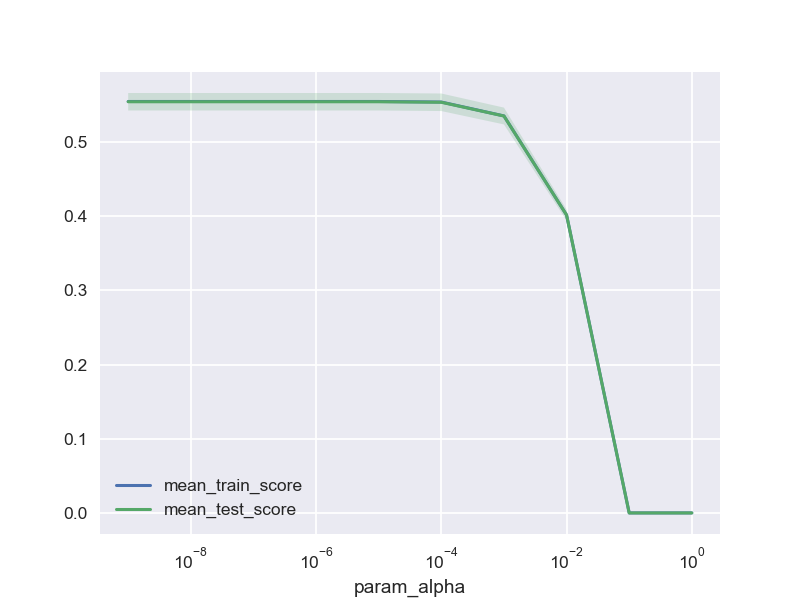

In [57]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xscale("log")

In [49]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 1e-05}
0.5544355017198797


In [131]:
model = Lasso(alpha = 0.0005, max_iter = 100, tol = 0.01)
model.fit(X_train,y_train)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.01, warm_start=False)

In [132]:
model.score(X_train,y_train)
model.coef_

array([ 0.   ,  0.   , -0.   , -0.   , -0.   , -0.   , -0.246,  0.036,
        0.01 , -0.   ,  0.208, -0.   , -0.069,  0.   , -0.031,  0.03 ,
       -0.   , -0.   , -0.371, -0.156,  0.   ,  0.127, -0.06 ,  0.   ,
        0.   , -0.   ,  0.065, -0.001,  0.177,  0.02 , -0.072, -0.007,
       -0.024, -0.008,  0.028,  0.091, -0.025,  0.   ,  0.078,  0.115,
        0.   , -0.046, -0.   , -0.042,  0.066,  0.144, -0.   , -0.   ,
        0.056, -0.011, -0.   ,  0.   ,  0.   ,  0.023,  0.   ,  0.   ,
       -0.139, -0.   , -0.   ,  0.022, -0.167,  0.   , -0.118, -0.099,
        0.   ,  0.026,  0.   ,  0.   , -0.128, -0.103, -0.071, -0.032,
       -0.008,  0.   ,  0.011,  0.001,  0.051,  0.072])

In [52]:
results['mean_train_score']

0    0.554786
1    0.554786
2    0.554786
3    0.554786
4    0.554775
5    0.554044
6    0.535314
7    0.401719
8    0.000000
9    0.000000
Name: mean_train_score, dtype: float64

In [53]:
results['mean_test_score']

0    0.554426
1    0.554426
2    0.554426
3    0.554427
4    0.554436
5    0.553727
6    0.535189
7    0.401687
8   -0.000056
9   -0.000056
Name: mean_test_score, dtype: float64

Feature selection of Model1

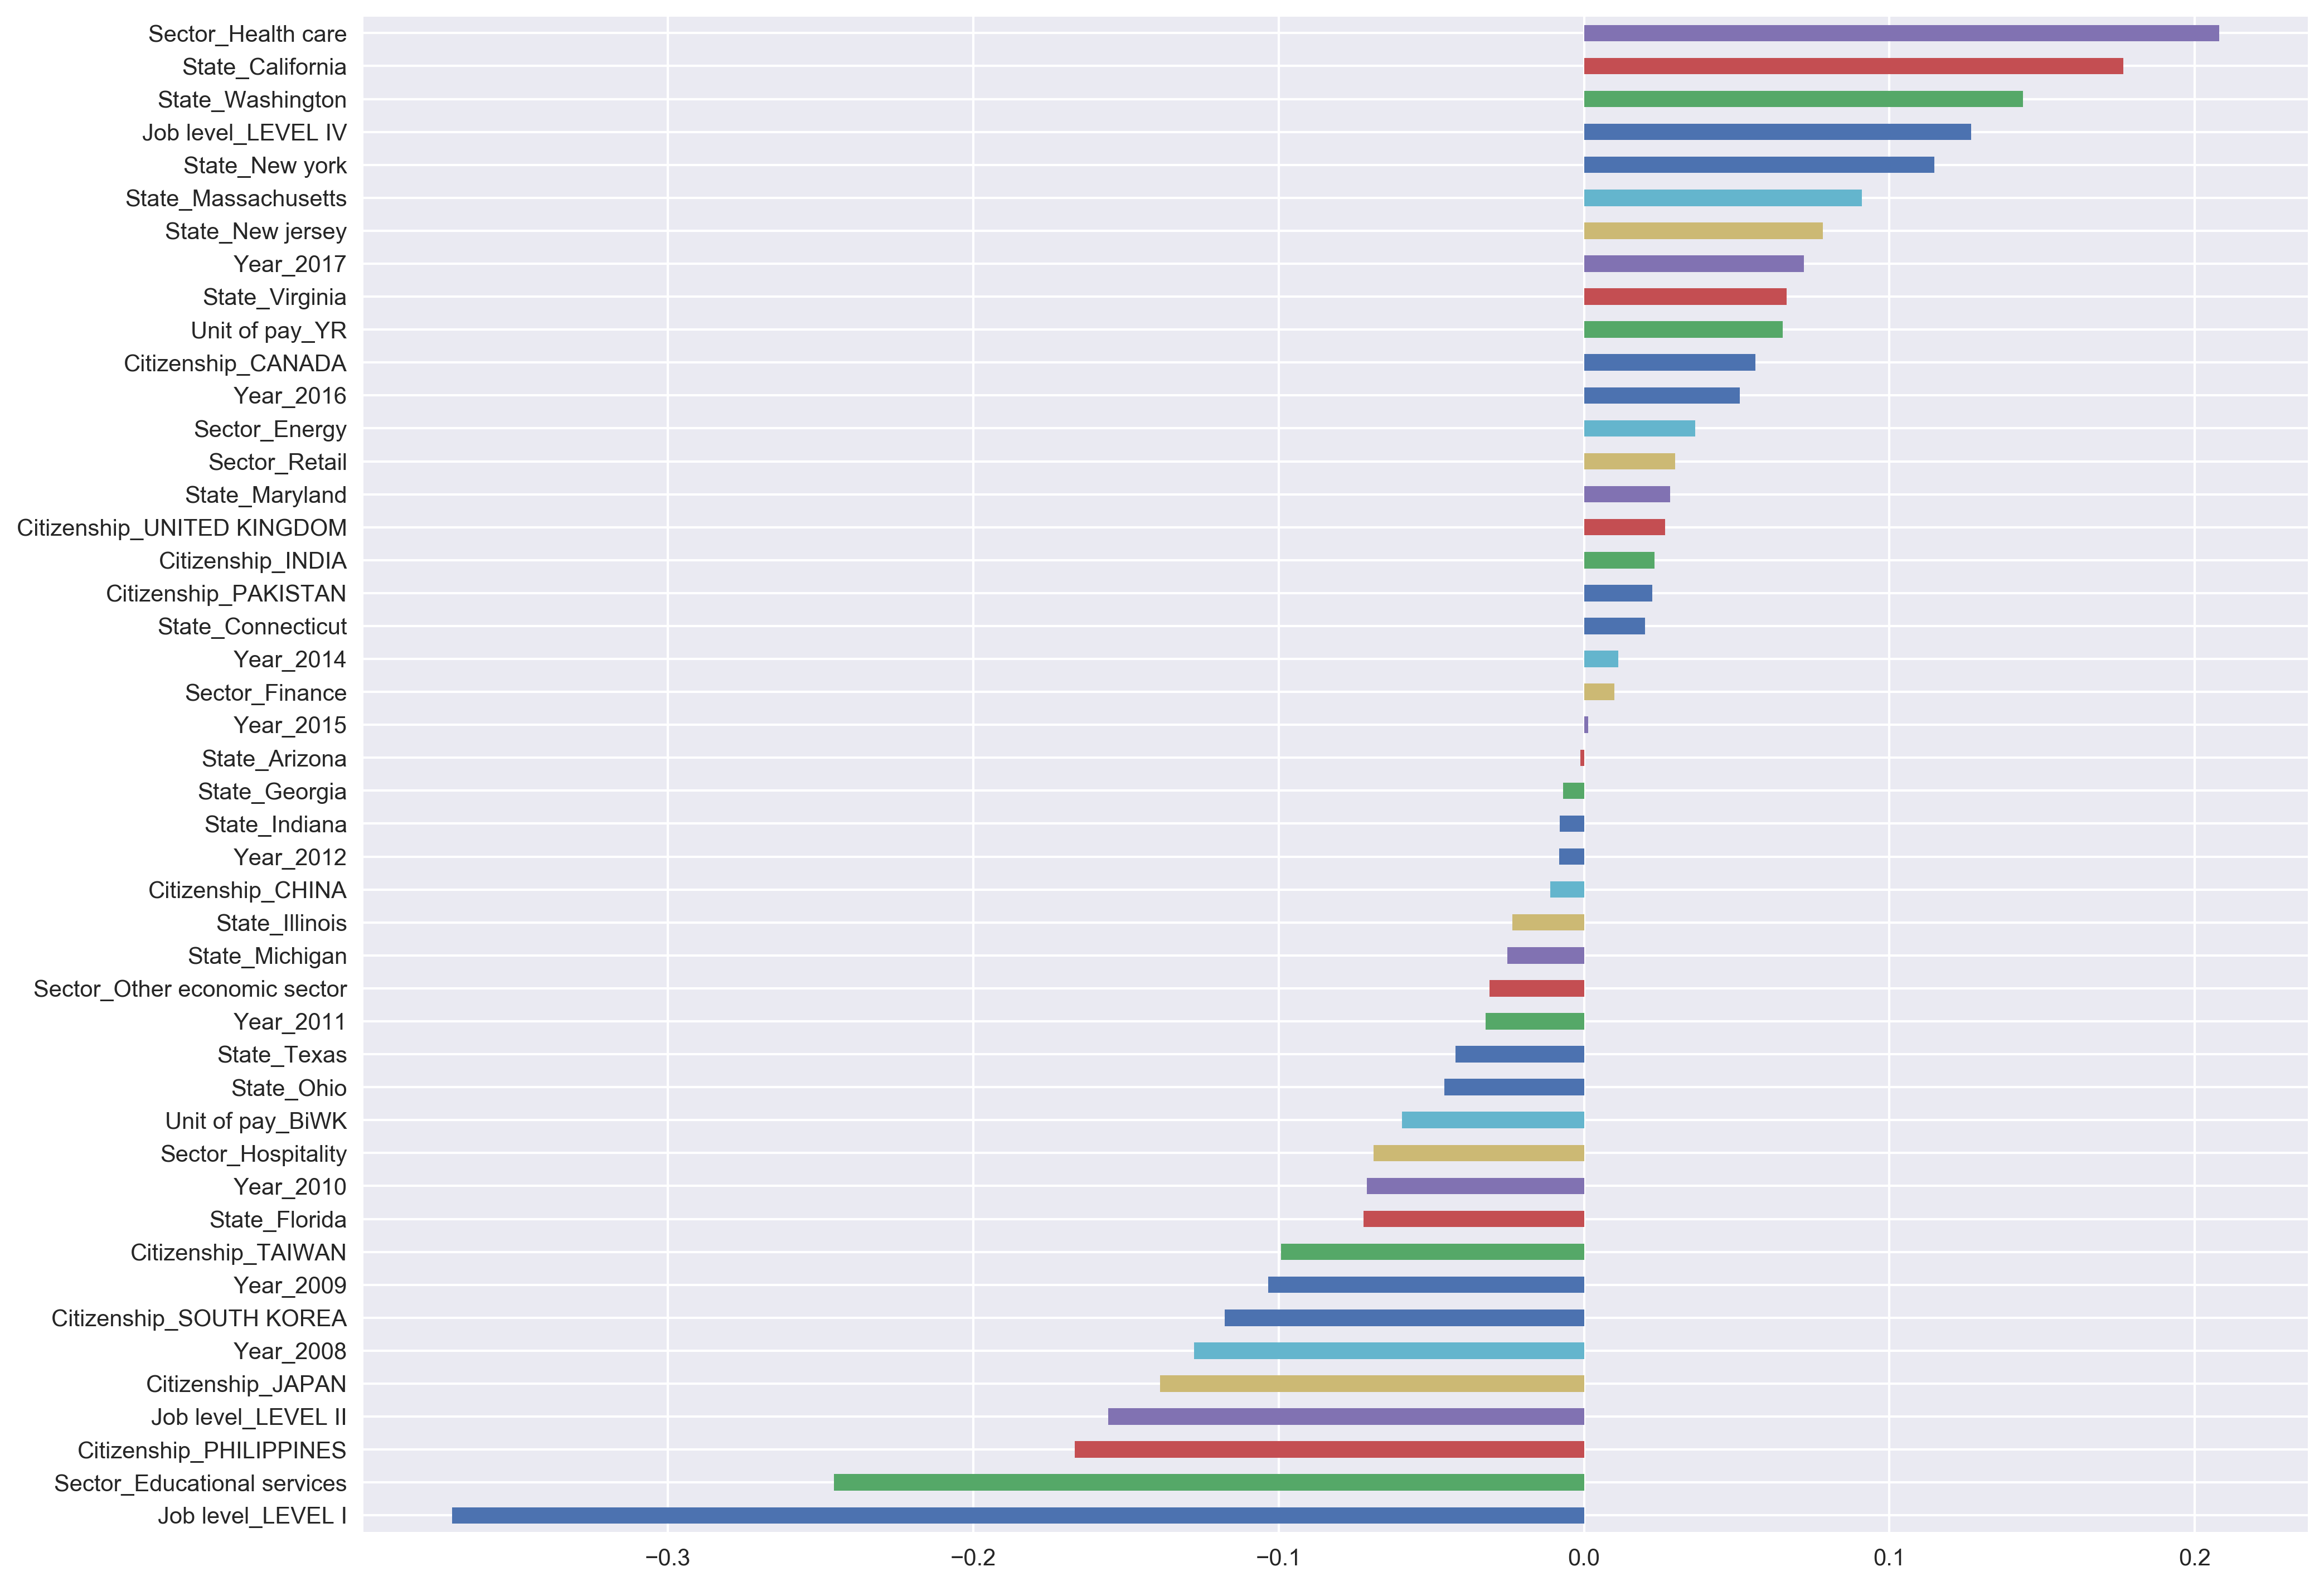

In [136]:
fig = plt.figure(figsize = (15,12))
ax = plt.subplot(111)
coefficient = pd.Series(index = X_train.columns, data = model.coef_)
coefficient[coefficient != 0].sort_values().plot(kind = 'barh', ax = ax)

In [ ]:
#from sklearn.linear_model import lars_path
# lars_path computes the exact regularization path which is piecewise linear.
#X_train, X_test, y_train, y_test = train_test_split(dataset1_onehot, dataset1_y, random_state=0)
#alphas, active, coefs = lars_path(X_train, y_train, eps=0.001, method="lasso")

In [41]:
cov = X_train.cov()
#plt.figure(figsize=(8, 8), dpi=100)
#plt.imshow(cov)
#plt.xticks(range(X.shape[1]), boston.feature_names)
#plt.yticks(range(X.shape[1]), boston.feature_names);

In [74]:
model = Lasso(max_iter = 200,alpha = grid.best_params_['alpha'], tol = 0.0001)
model.fit(X_train, y_train)
model.score(X_test,y_test)
#model.coef_

C:\Users\barry\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.553552817213836

In [75]:
model.score(X_train, y_train)

0.554752615091051

In [80]:
OLS = LinearRegression().fit(X_train,y_train)

In [81]:
OLS.score(X_train, y_train)

0.5546819285412523

In [82]:
OLS.score(X_test, y_test)

0.5534298258794113

Preprocessing for Model2 (including variables added after 2015)

In [35]:
code_new = ['CASE_NUMBER','EMPLOYER_NAME','NAICS_US_CODE','JOB_INFO_JOB_TITLE','PW_LEVEL_9089','PW_AMOUNT_9089','WAGE_OFFER_UNIT_OF_PAY_9089',
            'JOB_INFO_WORK_CITY','JOB_INFO_WORK_STATE','COUNTRY_OF_CITIZENSHIP','CLASS_OF_ADMISSION','Year',
           'JOB_INFO_EDUCATION','JOB_INFO_EXPERIENCE_NUM_MONTHS','FOREIGN_WORKER_INFO_MAJOR','FOREIGN_WORKER_INFO_INST','EMPLOYER_YR_ESTAB',
           'FW_OWNERSHIP_INTEREST','EMPLOYER_NUM_EMPLOYEES']
name_new = ['Case No','Employer','NAICS Code','Job title','Job level','Wage','Unit of pay','City','State','Citizenship','Class of admission','Year',
           'Education level','Job experience','Major','Institution','Year founded','Ownership interest','Employee number',]

In [36]:
dataPost2015_2 = dataPost2015[code_new]

In [37]:
dataPost2015_2.columns = name_new

In [38]:
dataPost2015_2['Job experience'] = dataPost2015_2['Job experience'].fillna(0)

C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Exploratory data analysis of new variables

<IPython.core.display.Javascript object>


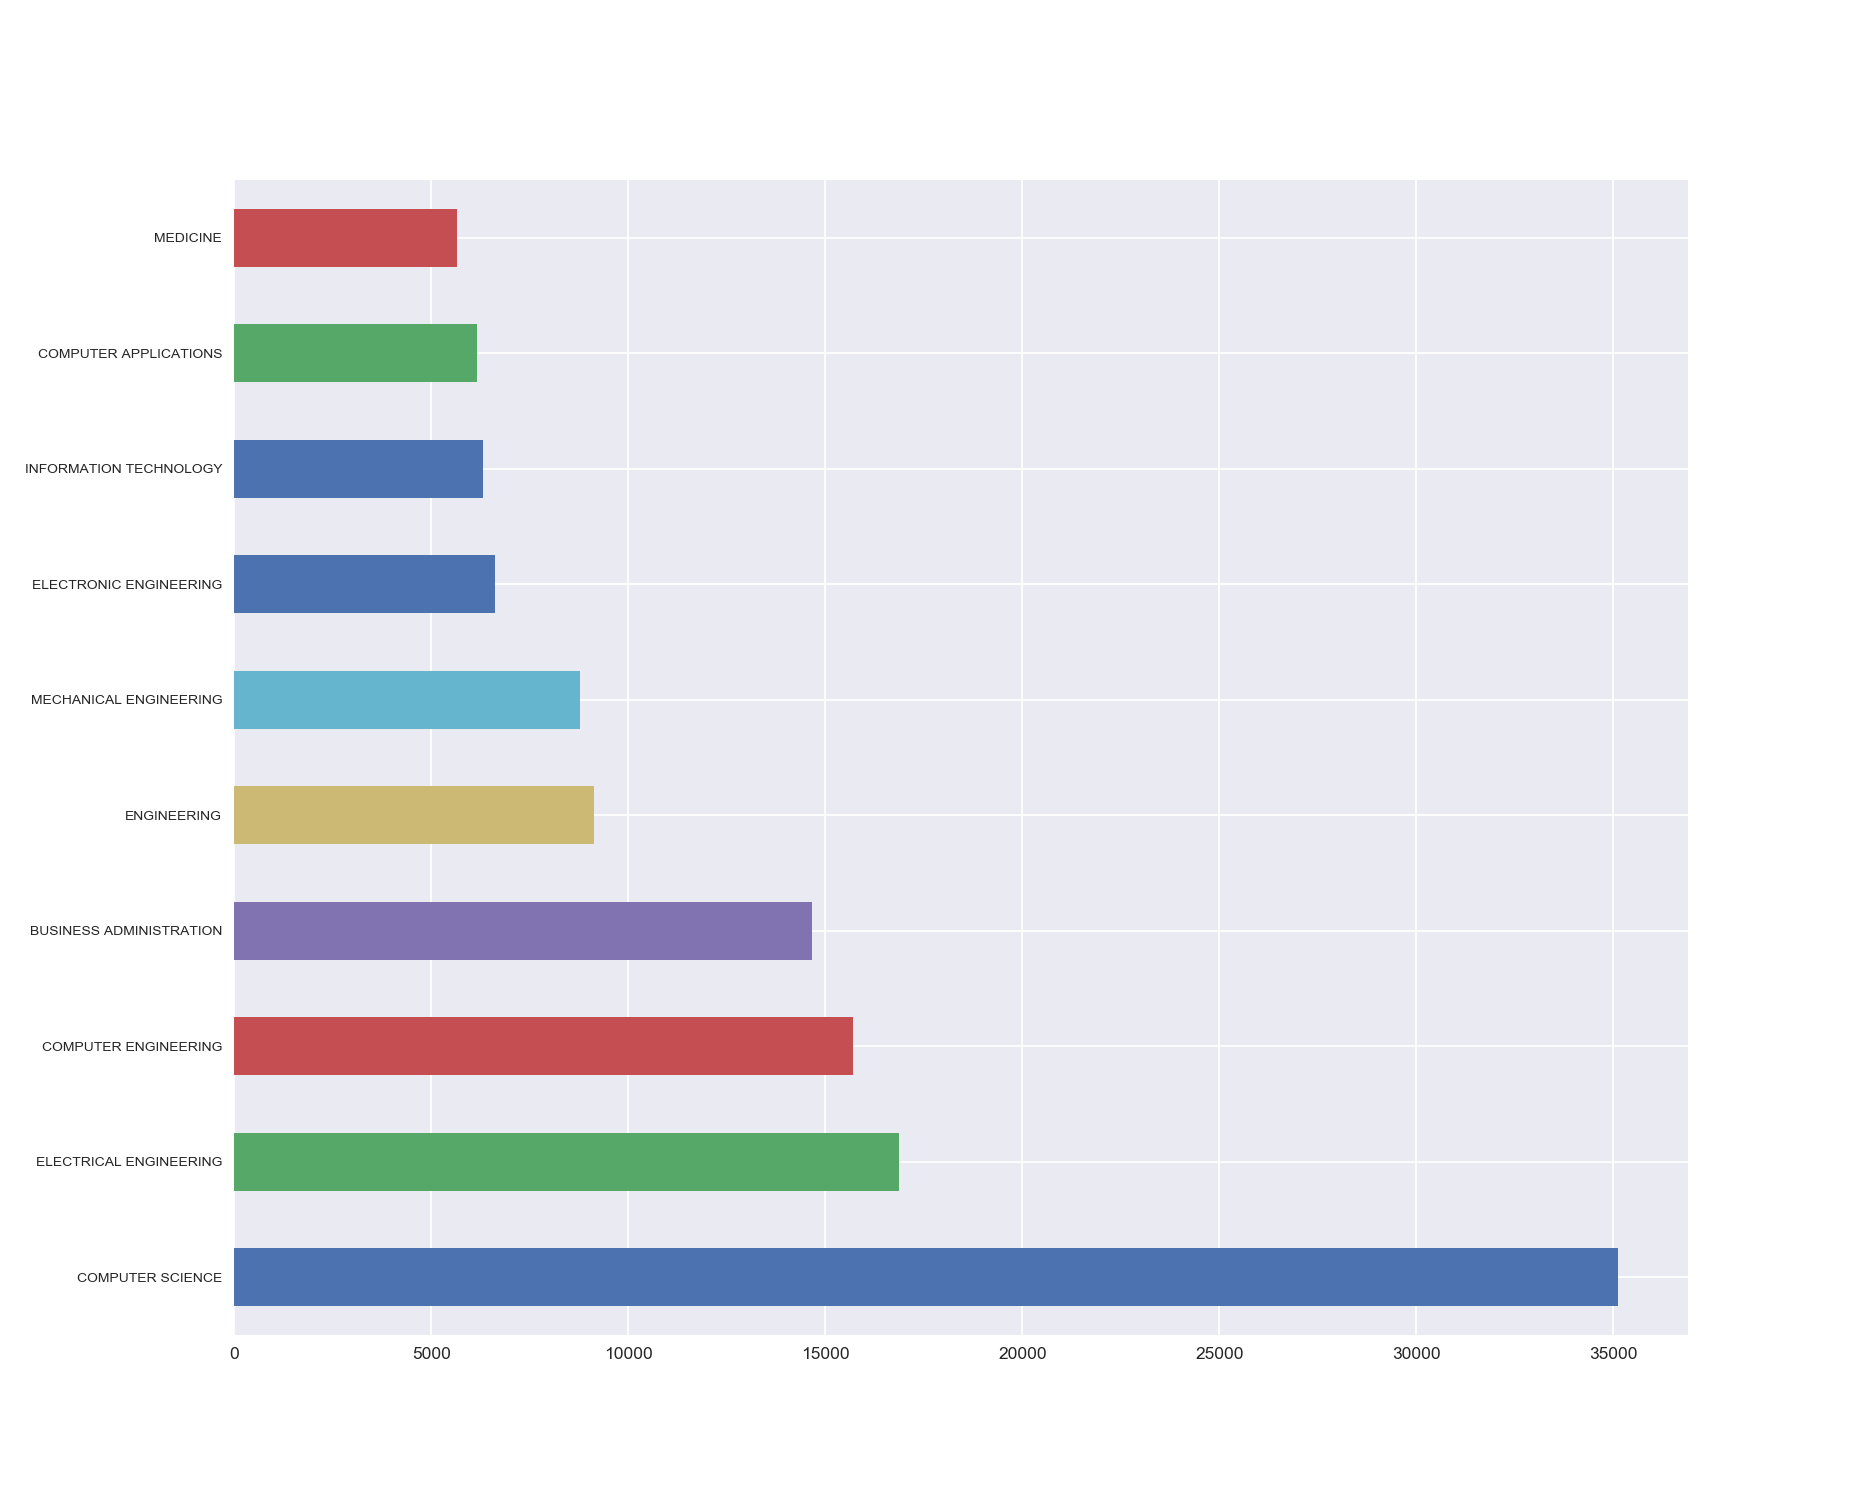

In [53]:
fig = plt.figure(figsize = (15,12))
ax = plt.subplot(111)
dataPost2015_2['Major'].value_counts()[:10].plot(kind = 'barh', ax = ax)
ax.tick_params(axis = 'y',which = 'major', labelsize = 8)

<IPython.core.display.Javascript object>


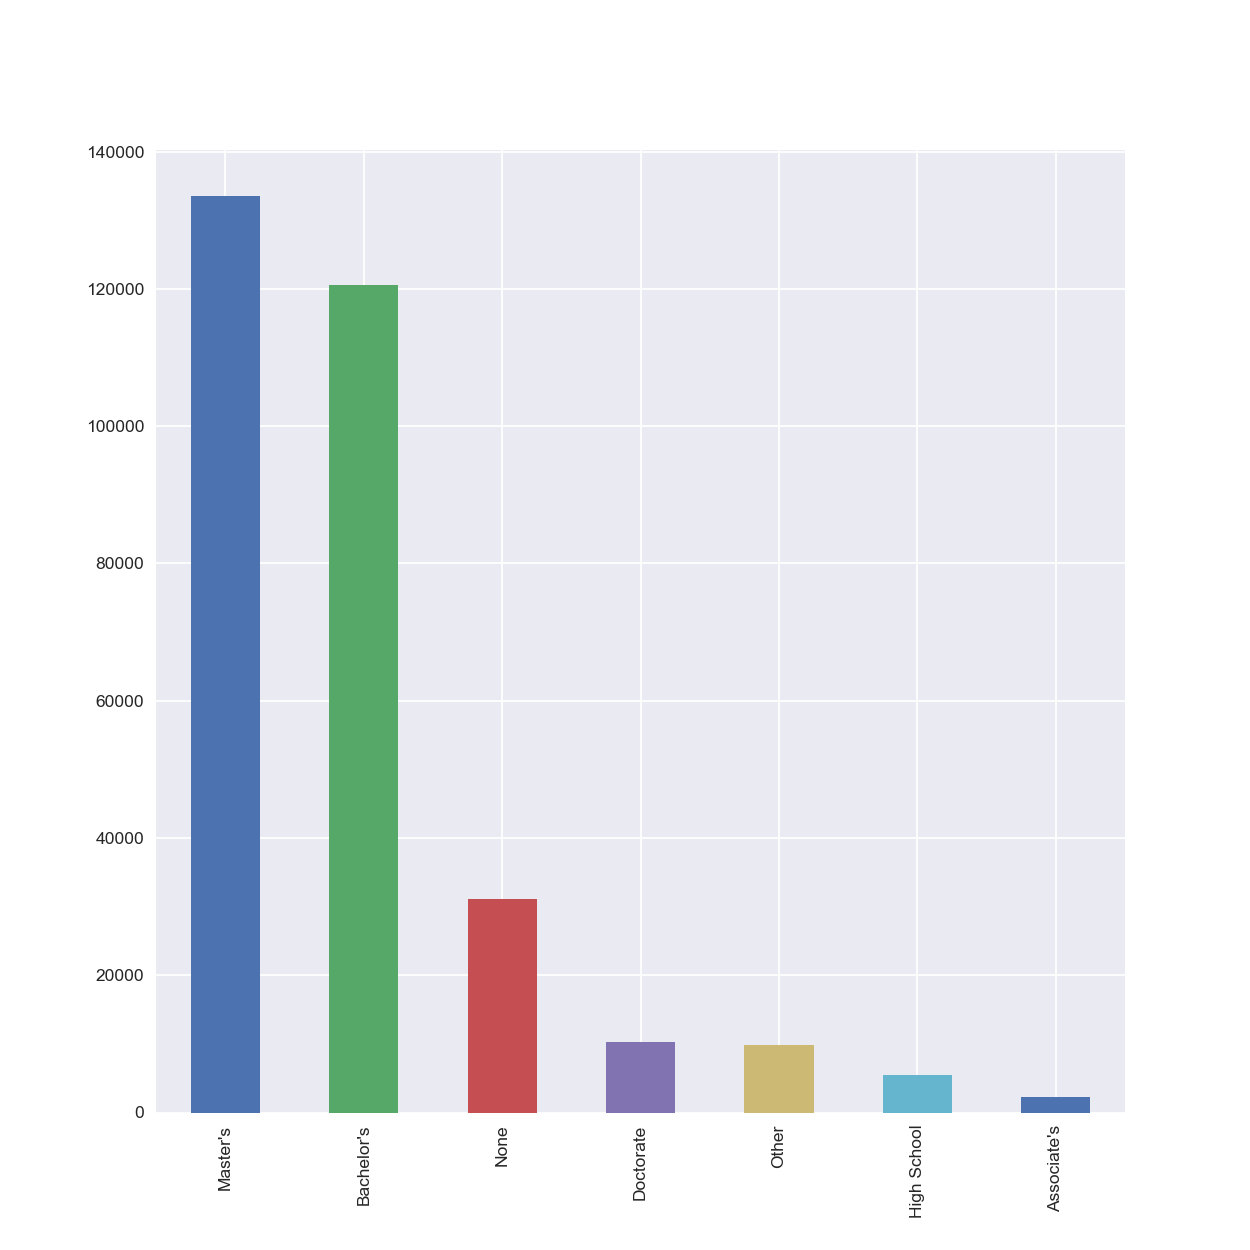

In [56]:
dataPost2015_2['Education level'].value_counts().plot(kind = 'bar', figsize = (10,10))
ax.tick_params(axis = 'y',which = 'major', labelsize = 8)

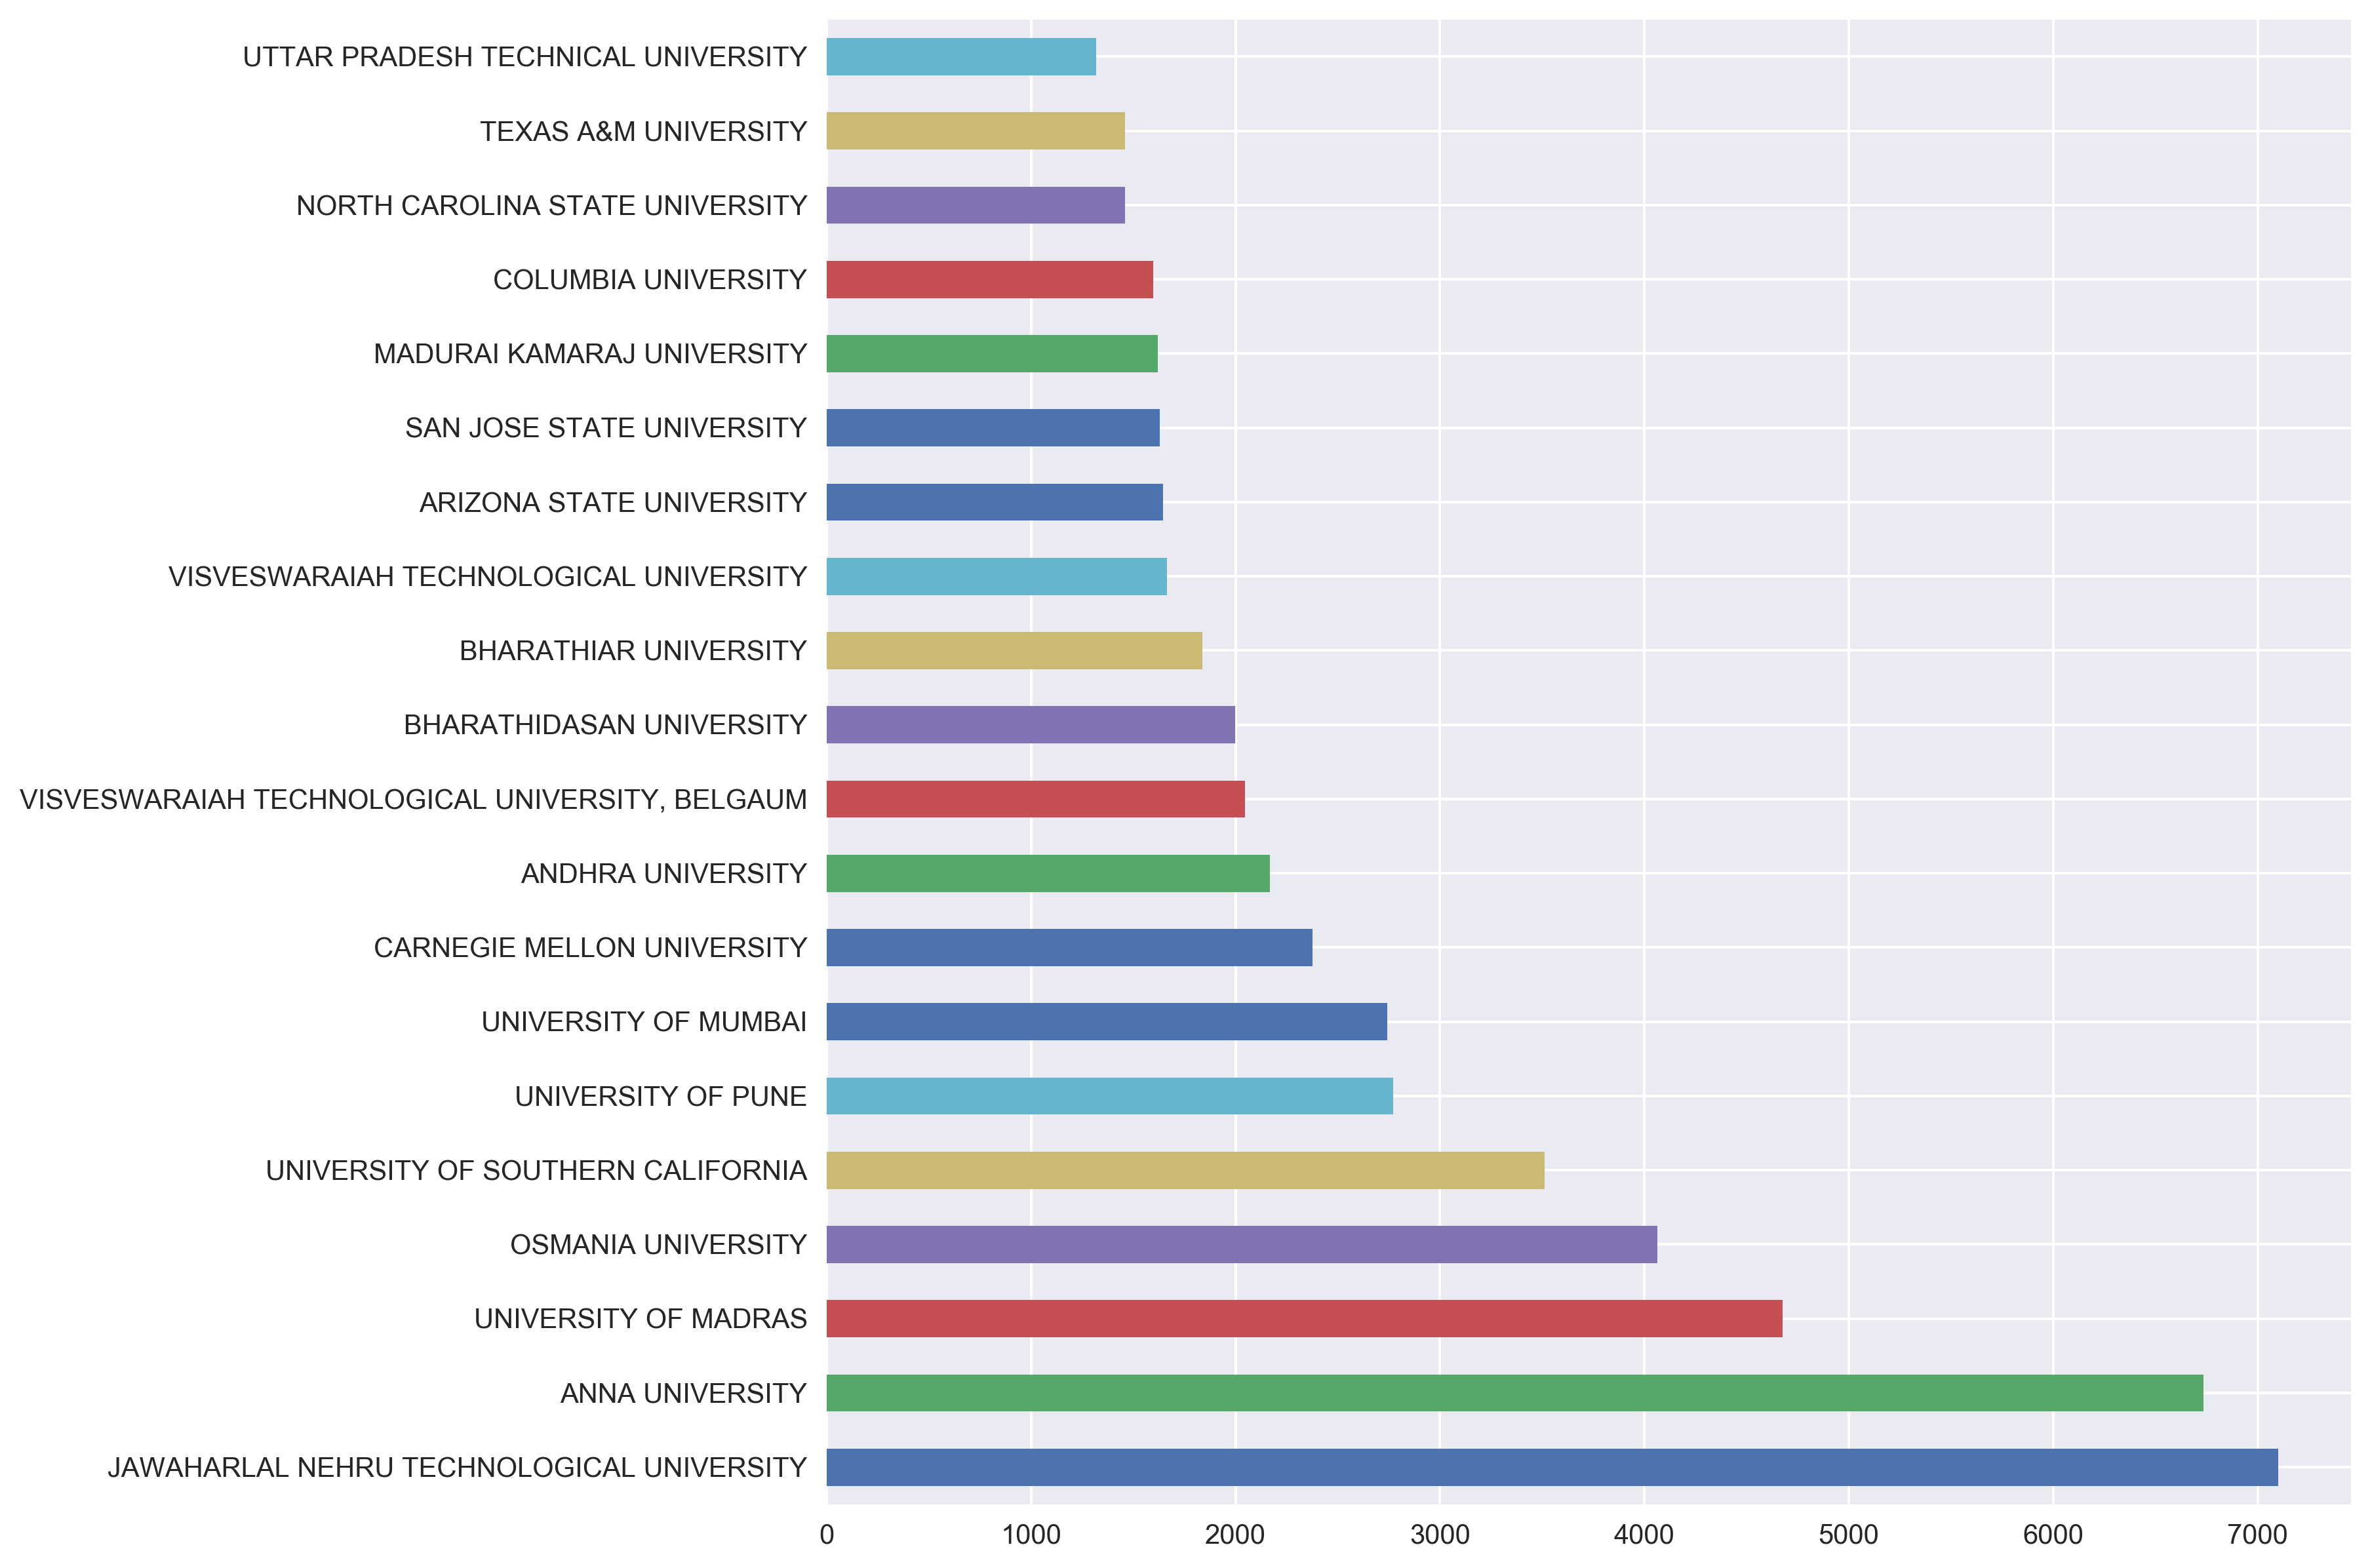

In [112]:
dataPost2015_2['Institution'].value_counts()[:20].plot(kind = 'barh', figsize = (10,10))
ax.tick_params(axis = 'y',which = 'major', labelsize = 8)

In [ ]:
dataPost2015_2['Sector'] = dataPost2015_2['NAICS Code'].apply(lambda x: f(x, code2sector))
dataset2 = dataPost2015_2[dataPost2015_2["Wage"] > 10000]
dataset2['Job level'] = dataset2['Job level'].str.upper()
dataset2['Sector'] = dataset2['Sector'].str.capitalize()
statemap = pd.read_excel('statemap.xlsx')
dataset2['State'] = dataset2['State'].replace(statemap['code'].values, statemap['state'].values)
dataset2['State'] = dataset2['State'].str.capitalize()
dataset2 = dataset2[dataset2['Class of admission'] == 'H-1B']

dataset2['Wage'] = dataset2['Wage'].astype('float')
year = ['YR','yr','Year']
month = ['MTH','mth','Month']
week = ['WK','wk','Week']
biweek = ['BI','bi','Bi-Weekly']
hour = ['HR','hr','Hour']
monthpay = dataset2['Unit of pay'].apply(lambda x: x in month)
dataset2['Wage'] = dataset2['Wage']*dataset2['Wage'].apply(lambda x: x < 100)*250*8 \
   + dataset2['Wage']*dataset2['Wage'].apply(lambda x: x > 100 and x < 1000)*50 \
    + dataset2['Wage']*dataset2['Wage'].apply(lambda x: x > 1000 and x < 20000)*12 \
    + dataset2['Wage']*dataset2['Wage'].apply(lambda x: x > 20000)
dataset2 = dataset2.dropna()
dataset2['Unit of pay'] = dataset2['Unit of pay'].apply(lambda x: g(x,year, month, week, hour, biweek))
dataset2_X = dataset2.set_index('Case No').drop(['Wage'],axis = 1)
dataset2_X = dataset2_X.reset_index()
dataset2_y = dataset2.set_index('Case No')['Wage']
dataset2_y = dataset2_y.reset_index()

(0, 500000)

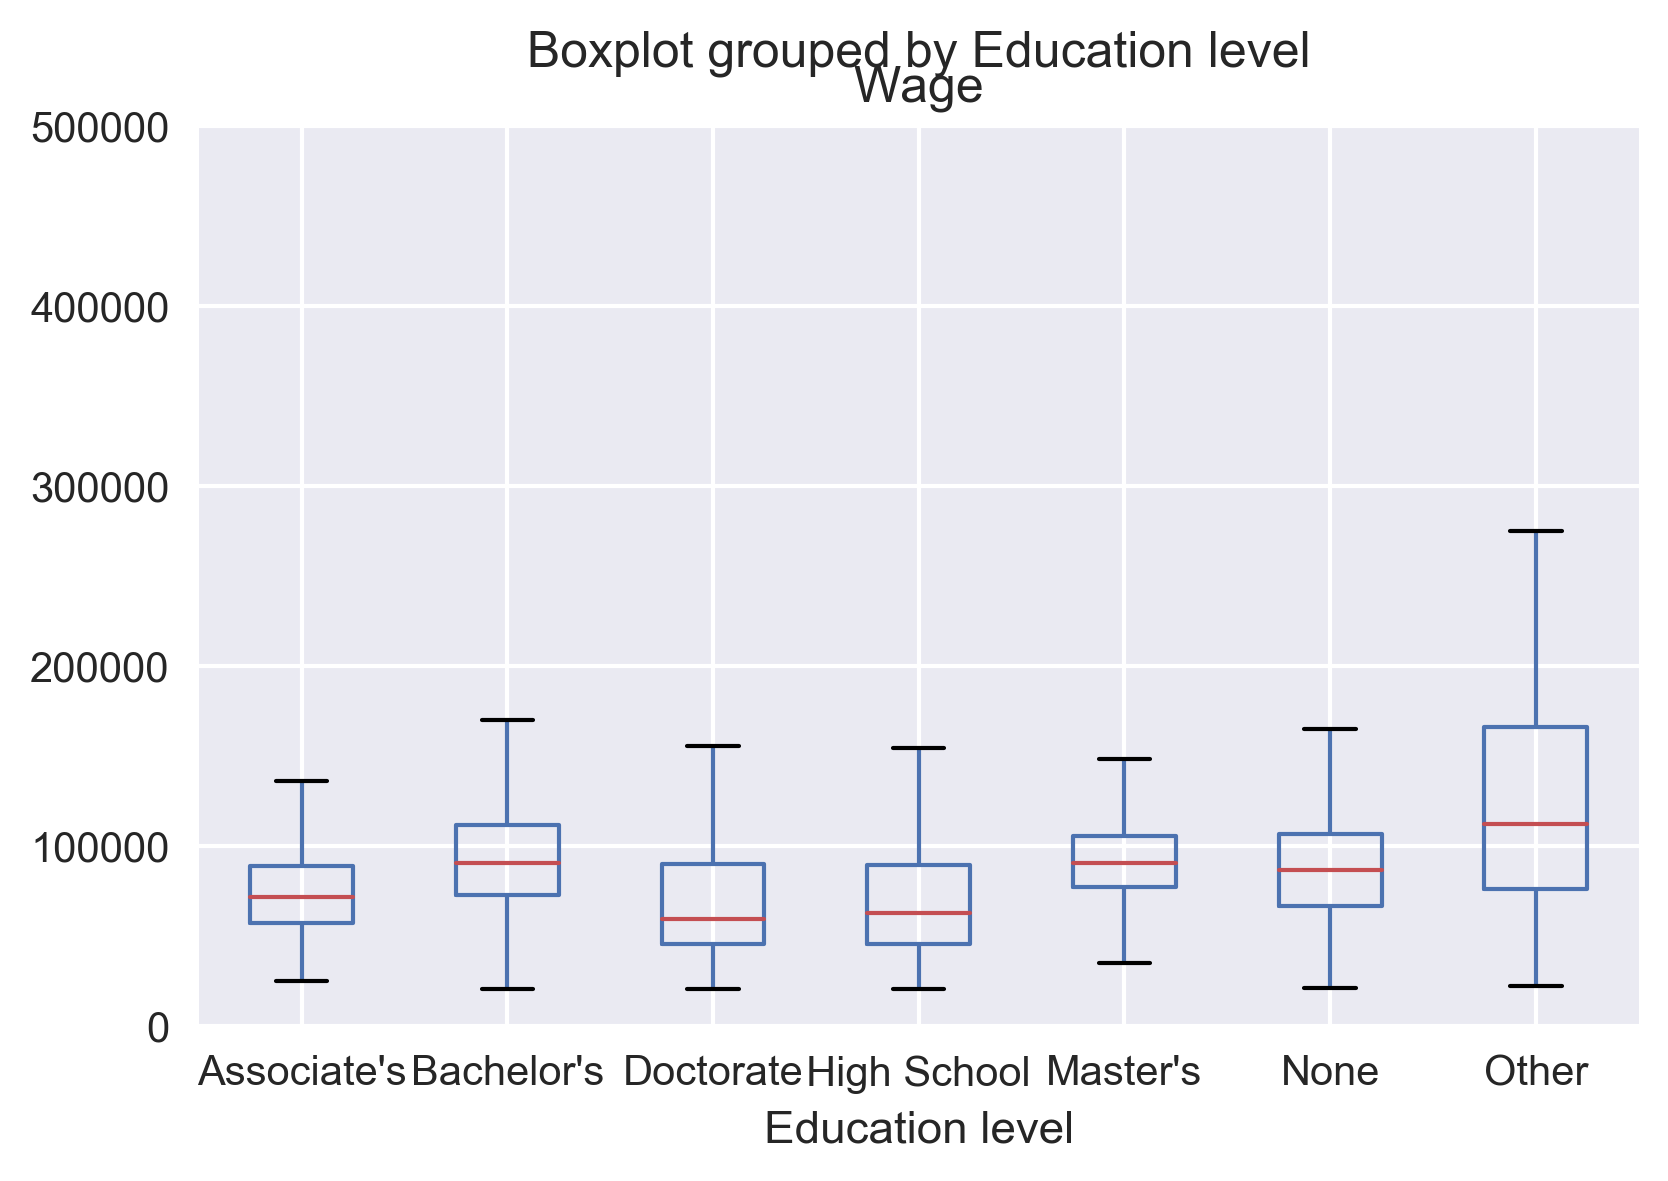

In [114]:
dataset2.boxplot('Wage','Education level')
plt.ylim(0,500000)

In [82]:
dataset2['Wage'].sort_values()[:-4]
dataset2['Wage'].sort_values()[:-4].index
#dataset2['Job experience'].loc[dataset2['Wage'].sort_values()[:-4].index]
#plt.scatter(dataset2.loc[dataset2['Wage'].sort_values()[:-4].index]['Job experience'], dataset2['Wage'].sort_values()[:-4])

Int64Index([ 57531,  47026,  22231,  71135,   8034,  17847,    161, 104230,
             39063,  46889,
            ...
             48613,  25908,  28436,  75451, 101012,  21787,  60165,  34799,
             44465,  43324],
           dtype='int64', length=198498)

In [137]:
top200 = dict.fromkeys(['Sector','Job level','Unit of pay','State','Citizenship','Class of admission','Year','Education level','Major','Institution','Ownership interest'])
for category in top200.keys():
    top200[category] = dataset2_X[category].value_counts()[:200].index
top200.keys()

dict_keys(['Sector', 'Job level', 'Unit of pay', 'State', 'Citizenship', 'Class of admission', 'Year', 'Education level', 'Major', 'Institution', 'Ownership interest'])

Use top 200 categories in each feature to construct feature space using one-hot mapping

In [142]:
dataset2_onehot = dataset2_X[['Sector','Job level','Unit of pay','State','Citizenship','Class of admission','Year','Education level','Major','Institution','Ownership interest','Job experience','Year founded','Employee number']].copy()
for category in top200.keys():
    dataset2_onehot = dataset2_onehot[dataset2_onehot[category].apply(lambda x: x in top200[category])]
dataset2_onehot = pd.get_dummies(dataset2_onehot, columns=list(top200.keys()),prefix = list(top200.keys()))
print('Original sample size: ' + str(len(dataset2_X.index)))
print('Sample size after selection: ' + str(len(dataset2_onehot.index)))

Original sample size: 198502
Sample size after selection: 91824


In [143]:
dataset2_y = dataset2_y['Wage'].loc[dataset2_onehot.index]
dataset2_y = np.log(dataset2_y)
X_train, X_test, y_train, y_test = train_test_split(dataset2_onehot, dataset2_y, random_state=0)

Training Model2 using 10-fold cross-validation

In [ ]:
param_grid = {'alpha': np.logspace(-9, 0, 10)}
grid = GridSearchCV(Lasso(max_iter=100, tol = 0.001), param_grid, cv=10, return_train_score=True, iid=False)
grid.fit(X_train, y_train)

In [172]:
grid.best_params_
grid.best_score_

0.6752083833009056

<IPython.core.display.Javascript object>


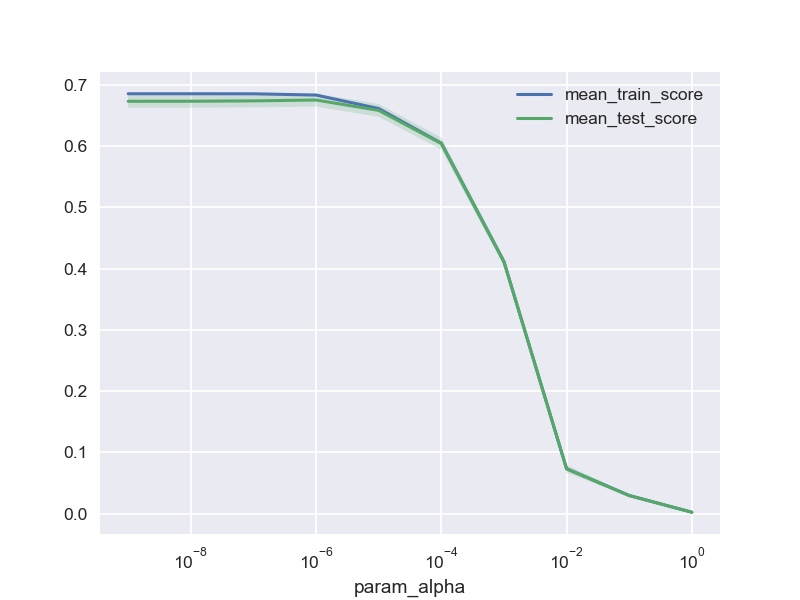

In [173]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xscale("log")

In [ ]:
model = Lasso(alpha = 1e-06, max_iter = 1000, tol = 0.1)
model.fit(X_train,y_train)

In [145]:
model.score(X_train, y_train)

0.6819648555313782

In [146]:
model.score(X_test,y_test)

0.6728505431121002

Feature selection of Model2

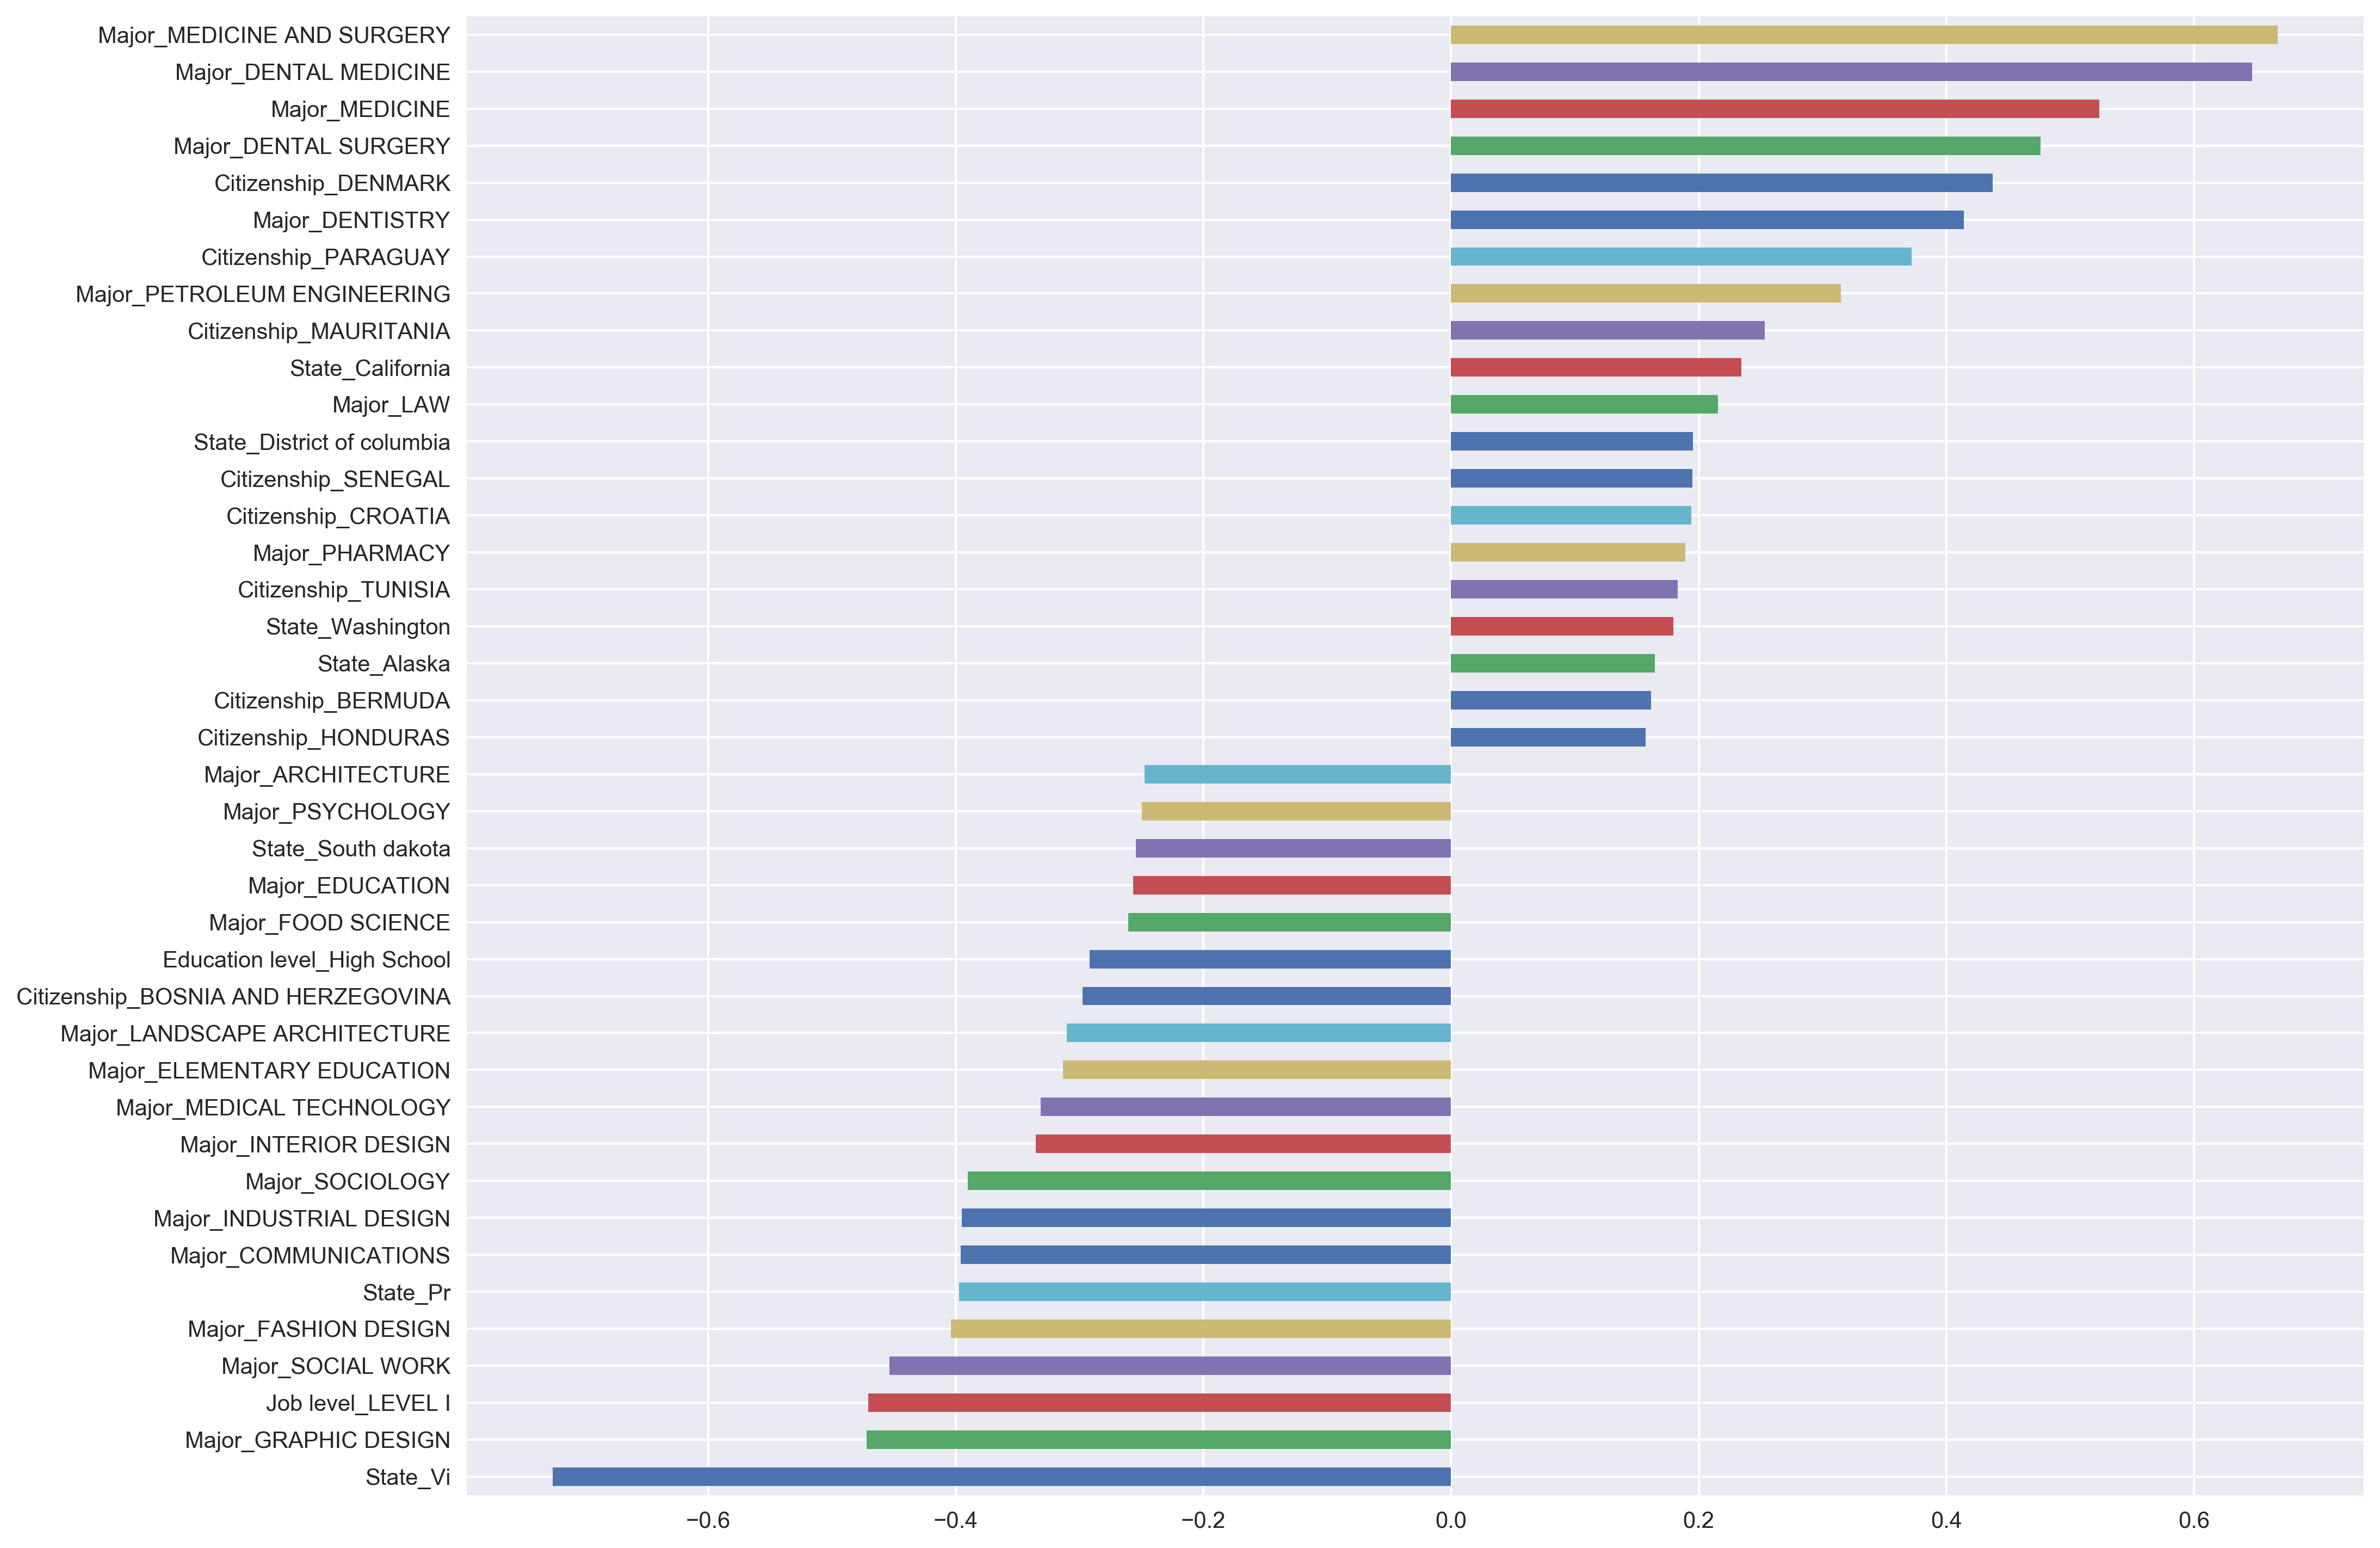

In [150]:
coefficient = pd.Series(index = X_train.columns, data = model.coef_)
fig = plt.figure(figsize = (15,12))
ax = plt.subplot(111)
coefficient[coefficient != 0].sort_values()[:20].append(coefficient[coefficient != 0].sort_values()[-20:]).plot(kind = 'barh', ax = ax)

In [194]:
coefficient = pd.Series(index = X_train.columns, data = model.coef_)
coefficient[coefficient != 0].sort_values()[-20:]

Institution_HARVARD UNIVERSITY       0.009371
Institution_YALE UNIVERSITY          0.009579
Institution_UNIVERSITY OF CHICAGO    0.010007
State_Dc                             0.011764
State_New jersey                     0.012428
State_Maryland                       0.012790
State_Virginia                       0.013099
State_Massachusetts                  0.013290
State_New york                       0.015299
Major_PHARMACY                       0.015670
Major_LAW                            0.017340
State_Washington                     0.018724
State_District of columbia           0.019106
State_California                     0.023300
Major_PETROLEUM ENGINEERING          0.026830
Major_DENTISTRY                      0.034833
Major_DENTAL SURGERY                 0.038761
Major_MEDICINE                       0.043752
Major_DENTAL MEDICINE                0.050195
Major_MEDICINE AND SURGERY           0.053052
dtype: float64

# Decision Tree

In [163]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"

np.set_printoptions(precision=3)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [164]:
code_new = ['CASE_STATUS','CASE_NUMBER','EMPLOYER_NAME','NAICS_US_CODE','JOB_INFO_JOB_TITLE','PW_LEVEL_9089','PW_AMOUNT_9089','WAGE_OFFER_UNIT_OF_PAY_9089',
            'JOB_INFO_WORK_CITY','JOB_INFO_WORK_STATE','COUNTRY_OF_CITIZENSHIP','CLASS_OF_ADMISSION','Year',
           'JOB_INFO_EDUCATION','JOB_INFO_EXPERIENCE_NUM_MONTHS','FOREIGN_WORKER_INFO_MAJOR','FOREIGN_WORKER_INFO_INST','EMPLOYER_YR_ESTAB',
           'FW_OWNERSHIP_INTEREST','EMPLOYER_NUM_EMPLOYEES']
name_new = ['Status','Case No','Employer','NAICS Code','Job title','Job level','Wage','Unit of pay','City','State','Citizenship','Class of admission','Year',
           'Education level','Job experience','Major','Institution','Year founded','Ownership interest','Employee number',]

In [165]:
dataPost2015_3 = dataPost2015[code_new]

In [166]:
dataPost2015_3.columns = name_new

In [ ]:
dataPost2015_3['Job experience'] = dataPost2015_3['Job experience'].fillna(0)

In [ ]:
dataPost2015_3['Sector'] = dataPost2015_3['NAICS Code'].apply(lambda x: f(x, code2sector))
dataset3 = dataPost2015_3[dataPost2015_3["Wage"] > 10000]
dataset3['Job level'] = dataset3['Job level'].str.upper()
dataset3['Sector'] = dataset3['Sector'].str.capitalize()
statemap = pd.read_excel('statemap.xlsx')
dataset3['State'] = dataset3['State'].replace(statemap['code'].values, statemap['state'].values)
dataset3['State'] = dataset3['State'].str.capitalize()
dataset3 = dataset3[dataset3['Class of admission'] == 'H-1B']
dataset3['Ownership interest'] = dataset3['Ownership interest'] == 'Y'

dataset3['Wage'] = dataset3['Wage'].astype('float')
year = ['YR','yr','Year']
month = ['MTH','mth','Month']
week = ['WK','wk','Week']
biweek = ['BI','bi','Bi-Weekly']
hour = ['HR','hr','Hour']
monthpay = dataset3['Unit of pay'].apply(lambda x: x in month)
dataset3['Wage'] = dataset3['Wage']*dataset3['Wage'].apply(lambda x: x < 100)*250*8 \
   + dataset3['Wage']*dataset3['Wage'].apply(lambda x: x > 100 and x < 1000)*50 \
    + dataset3['Wage']*dataset3['Wage'].apply(lambda x: x > 1000 and x < 20000)*12 \
    + dataset3['Wage']*dataset3['Wage'].apply(lambda x: x > 20000)
dataset3 = dataset3.dropna()
dataset3['Unit of pay'] = dataset3['Unit of pay'].apply(lambda x: g(x,year, month, week, hour, biweek))
dataset3 = dataset3[dataset3['Status'] != 'Withdrawn']
dataset3_X = dataset3.set_index('Case No').drop(['Status'],axis = 1)
dataset3_X = dataset3_X.reset_index()
dataset3_y = dataset3.set_index('Case No')['Status']
dataset3_y = dataset3_y.reset_index()

In [ ]:
# dataset3_X = dataset3_X[['Job level','Wage','Unit of pay','City','State','Citizenship','Class of admission','Year','Education level',
#           'Job experience','Major','Institution','Year founded','Ownership interest','Employee number','Sector']].copy()
# dataset3_y = dataset3_y.drop('Case No', axis = 1)
dataset3_X = dataset3_X[['Job level','Wage','Unit of pay','City','State','Class of admission','Education level',
          'Job experience','Major','Year founded','Ownership interest','Employee number','Sector']].copy()
dataset3_y = dataset3_y.drop('Case No', axis = 1)

In [171]:
dataset3_y['Status'].unique()

array(['Certified-Expired', 'Certified', 'Denied'], dtype=object)

In [172]:
dataset3_y = dataset3_y.replace('Certified-Expired','Certified')

In [173]:
dataset3_y['Status'].value_counts()

Certified    184308
Denied         7385
Name: Status, dtype: int64

In [174]:
top200 = dict.fromkeys(['Sector','Job level','Unit of pay','State','Class of admission','Education level','Major'])
for category in top200.keys():
    top200[category] = dataset3_X[category].value_counts()[:200].index
    
dataset3_onehot = dataset3_X[['Sector','Job level','Unit of pay','State','Class of admission','Education level','Major','Ownership interest','Job experience','Year founded','Employee number']].copy()
for category in top200.keys():
    dataset3_onehot = dataset3_onehot[dataset3_onehot[category].apply(lambda x: x in top200[category])]
dataset3_onehot = pd.get_dummies(dataset3_onehot, columns=list(top200.keys()),prefix = list(top200.keys()))
print('Original sample size: ' + str(len(dataset3_X.index)))
print('Sample size after selection: ' + str(len(dataset3_onehot.index)))

Original sample size: 191693
Sample size after selection: 155266


In [175]:
X_train, X_test, y_train, y_test = train_test_split(dataset3_onehot.values, dataset3_y.apply(lambda x: x == 'Certified').loc[dataset3_onehot.index].values, random_state=0)

In [246]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [259]:
tree.score(X_test, y_test)

0.971442705522576

In [260]:
tree.score(X_train, y_train)

0.9730762888452487

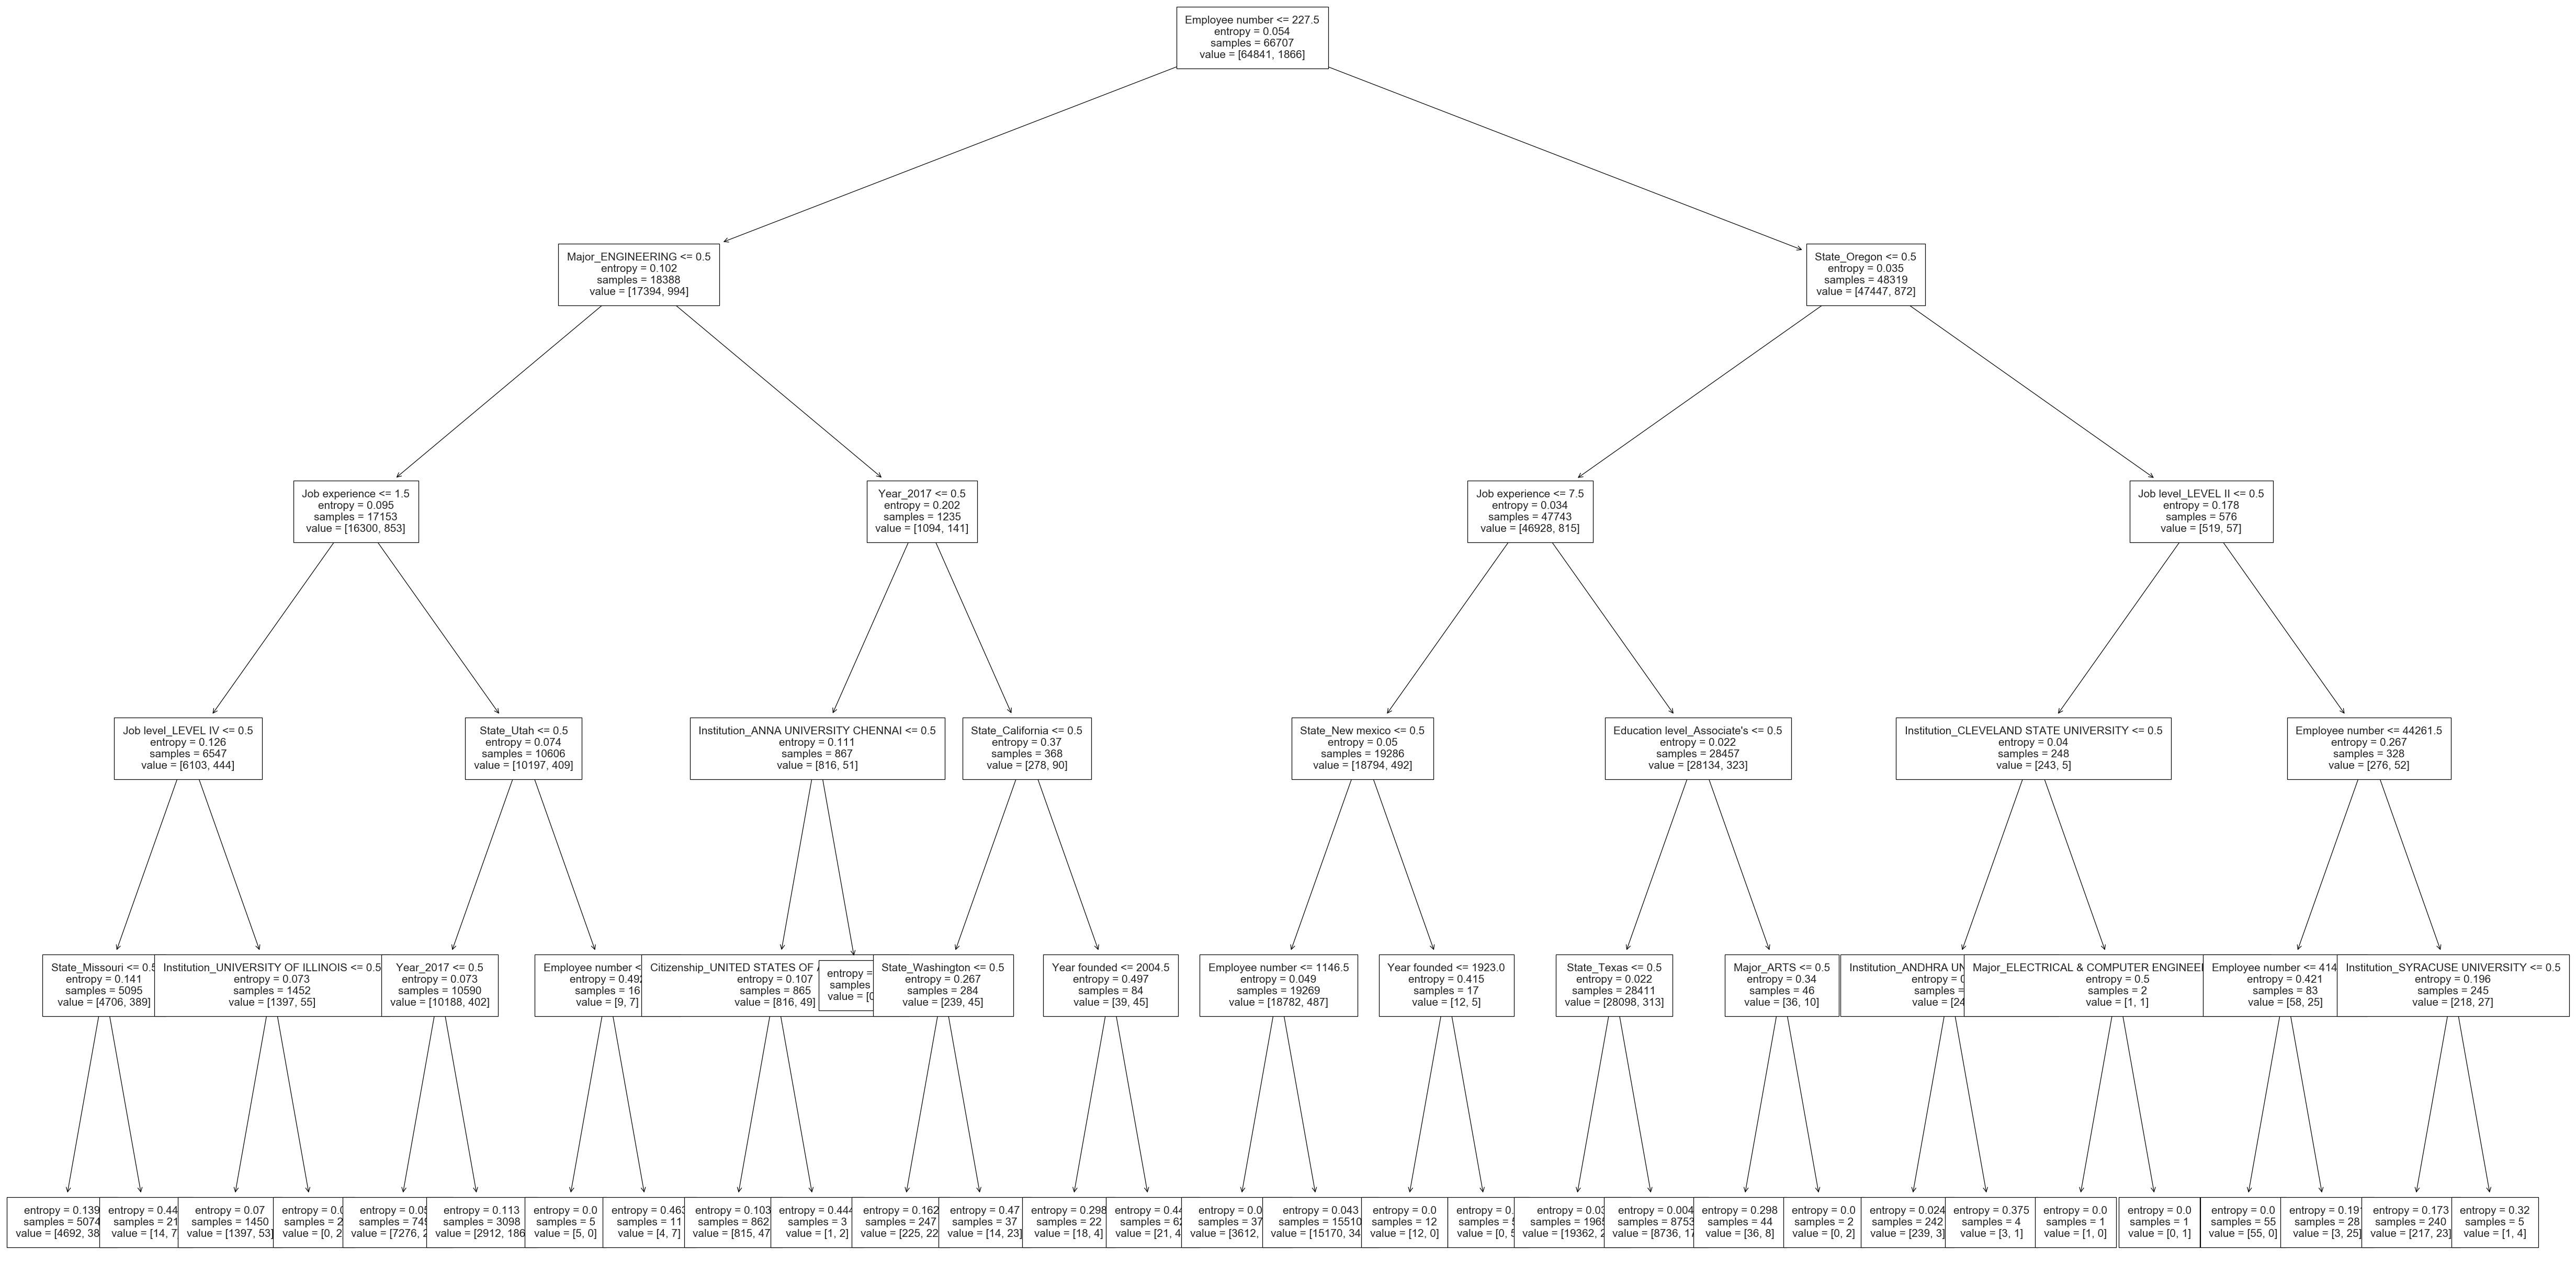

In [266]:
from tree_plotting import plot_tree
plt.figure(figsize=(20, 10))
tree_dot = plot_tree(tree, feature_names=X_train.columns,fontsize = 5)
plt.savefig("h1b_tree_plot.png")

## Certification prediction: Logistic regression

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

score = cross_validate(LogisticRegression(), X_train, y_train[:,0], 
                       cv=10, scoring = ('roc_auc', 'average_precision'))

In [181]:
score['test_roc_auc'].mean()

0.5349616579641193

In [ ]:
from sklearn.ensemble import RandomForestClassifier
score = cross_validate(RandomForestClassifier(n_estimators = 100), X_train, y_train, 
                       cv=10, scoring = ('roc_auc', 'average_precision'))

Random Sampling

In [185]:
RandomUnderSampler(sampling_strategy = 0.5)

RandomUnderSampler(random_state=None, ratio=None, replacement=False,
          return_indices=False, sampling_strategy=0.5)

In [189]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(replacement = False, sampling_strategy = 1)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample[:,0]))

(116449, 299)
(8280, 299)
[4140 4140]


In [ ]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.linear_model import LogisticRegressionCV

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_validate(undersample_pipe, X_train, y_train, cv=10, scoring = 'roc_auc')

In [ ]:
scores['test_score'].mean()

In [199]:
RandomOverSampler?

In [198]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy = 1)
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

C:\Users\barry\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(116449, 299)
(224618, 299)
[112309 112309]


In [ ]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_validate(oversample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve
oversample_pipe.fit(X_train, y_train)
probs_oversample = oversample_pipe.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)
precision_over, recall_over, _ = precision_recall_curve(y_test, probs_oversample)

undersample_pipe.fit(X_train, y_train)
probs_undersample = undersample_pipe.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)
precision_under, recall_under, _ = precision_recall_curve(y_test, probs_undersample)

lr = LogisticRegression(penalty = 'l1', C = 100).fit(X_train, y_train)
probs_original = lr.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)
precision_org, recall_org, _ = precision_recall_curve(y_test, probs_original)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("LogReg ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("LogReg PR curve")
plt.tight_layout()
#plt.savefig("images/curves_logreg.png")

In [369]:


from sklearn.metrics import roc_auc_score
auc=roc_auc_score(y_test, probs_original)
auc

0.6803935870294928

### Grid search for the best hyperparameter C

Try different sampling ratio, plot sampling ratio against AUC

In [ ]:
gridC = np.logspace(-5,3,10)
over_scores = []
under_scores = []
original_scores = []

result = pd.DataFrame(index = np.linspace(0.05,1,20), columns = ['Over','Under','Original'])
Cgrid = [0.0001,0.1,1,100]
for C in Cgrid:
    for ratio in np.linspace(0.05,1,20):
        oversample_pipe = make_imb_pipeline(RandomOverSampler(sampling_strategy = ratio), LogisticRegression(penalty = 'l1',C = C))
        scores_over = cross_validate(oversample_pipe,
                            X_train, y_train, cv=10, scoring='roc_auc')['test_score'].mean()
        undersample_pipe = make_imb_pipeline(RandomUnderSampler(sampling_strategy = ratio), LogisticRegression(penalty = 'l1',C = C))
        scores_under = cross_validate(undersample_pipe,
                            X_train, y_train, cv=10, scoring='roc_auc')['test_score'].mean()    
        original = LogisticRegression(penalty = 'l1',C = C)
        result['Original'][ratio] = cross_validate(original, X_train, y_train, cv=10, scoring = 'roc_auc')['test_score'].mean()
        result['Over'][ratio] = scores_over
        result['Under'][ratio] = scores_under
    result.plot()
    plt.xlabel('Sampling ratio')
    plt.ylabel('AUC score')
    plt.title('Random sampling scores with different sampling ratio: c = '+ str(C))

In [ ]:
gridC = np.logspace(-5,3,10)
over_scores = []
under_scores = []
original_scores = []

result = pd.DataFrame(index = np.linspace(0.05,1,20), columns = ['Over','Under','Original'])
Cgrid = [0.0001,0.1,1,100]
for C in Cgrid:
    for ratio in np.linspace(0.05,1,20):
        oversample_pipe = make_imb_pipeline(RandomOverSampler(sampling_strategy = ratio), LogisticRegression(C = C))
        scores_over = cross_validate(oversample_pipe,
                            X_train, y_train, cv=10, scoring='roc_auc')['test_score'].mean()
        undersample_pipe = make_imb_pipeline(RandomUnderSampler(sampling_strategy = ratio), LogisticRegression(C = C))
        scores_under = cross_validate(undersample_pipe,
                            X_train, y_train, cv=10, scoring='roc_auc')['test_score'].mean()    
        original = LogisticRegression(C = C)
        result['Original'][ratio] = cross_validate(original, X_train, y_train, cv=10, scoring = 'roc_auc')['test_score'].mean()
        result['Over'][ratio] = scores_over
        result['Under'][ratio] = scores_under
    result.plot()
    plt.xlabel('Sampling ratio')
    plt.ylabel('AUC score')
    plt.title('Random sampling scores with different sampling ratio: c = '+ str(C))

Text(0.5,1,'Random sampling scores with different sampling ratio: c = 1')

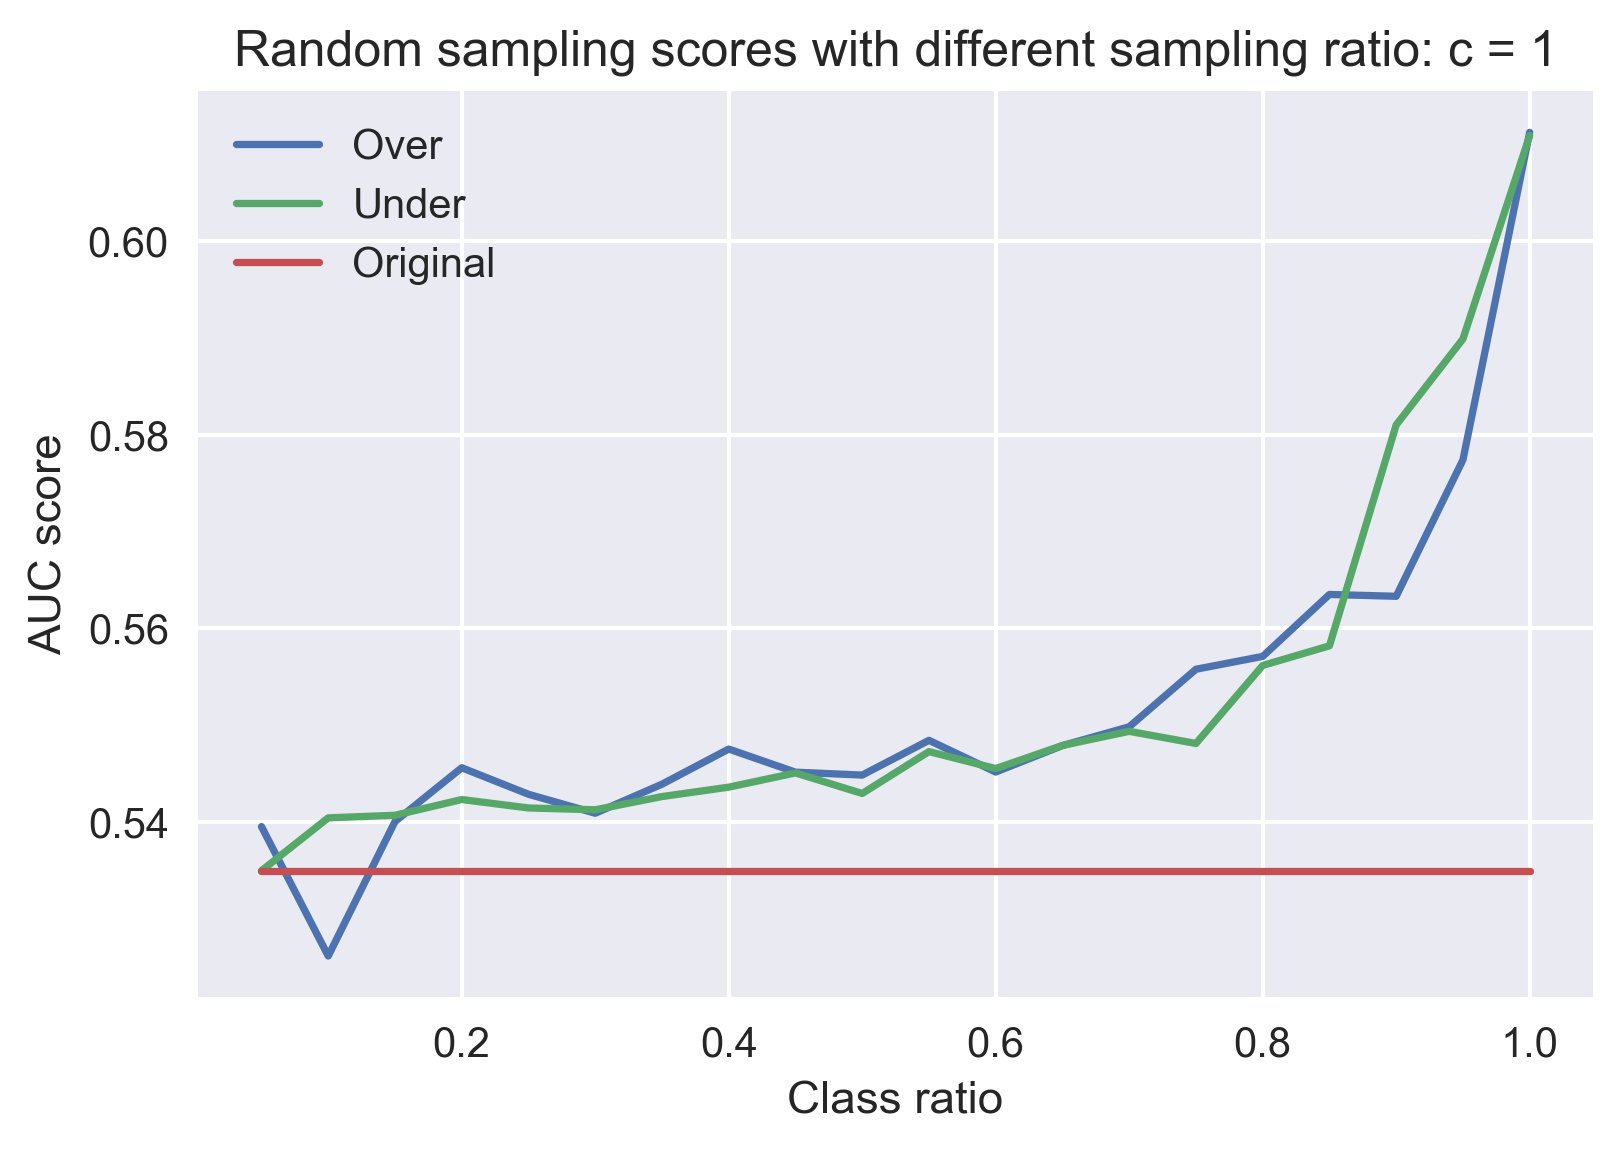

In [202]:
result.plot()
plt.xlabel('Sampling ratio')
plt.ylabel('AUC score')
plt.title('Random sampling scores with different sampling ratio: c = '+ str(C))

In [397]:
under_scores.index(max(under_scores))

14

In [ ]:
cs = [gridC[over_scores.index(max(over_scores))], gridC[under_scores.index(max(under_scores))], 
            gridC[original_scores.index(max(original_scores))]]
c = 1
for ratio np.linspace(0,1,10):
    oversample_pipe = make_imb_pipeline(RandomOverSampler(sampling_strategy = ratio), LogisticRegression(C = c))
    undersample_pipe = make_imb_pipeline(RandomUnderSampler(sampling_strategy = ratio), LogisticRegression(C = c))
    oversample_pipe.fit(X_train, y_train)
    probs_oversample = oversample_pipe.predict_proba(X_test)[:, 1]
    fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)
    precision_over, recall_over, _ = precision_recall_curve(y_test, probs_oversample)

    undersample_pipe.fit(X_train, y_train)
    probs_undersample = undersample_pipe.predict_proba(X_test)[:, 1]
    fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)
    precision_under, recall_under, _ = precision_recall_curve(y_test, probs_undersample)

    
    lr = LogisticRegression(penalty = 'l1', C = c).fit(X_train, y_train)
    probs_original = lr.predict_proba(X_test)[:, 1]
    fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)
    precision_org, recall_org, _ = precision_recall_curve(y_test, probs_original)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
    axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
    axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
    axes[0].legend()
    axes[0].set_xlabel("FPR")
    axes[0].set_ylabel("TPR")
    axes[0].set_title("LogReg ROC curve")

    axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
    axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
    axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
    axes[1].legend()
    axes[1].set_xlabel("recall")
    axes[1].set_ylabel("precision")
    axes[1].set_title("LogReg PR curve")
    plt.tight_layout()
#plt.savefig("images/curves_logreg.png")

In [ ]:
lr = LogisticRegression(penalty = 'l1', C = 0.05).fit(X_train, y_train)
lr.score(X_test, y_test)

In [103]:
feature_weights = pd.Series(index = dataset3_onehot.columns, data = lr.coef_[0])

Feature selection

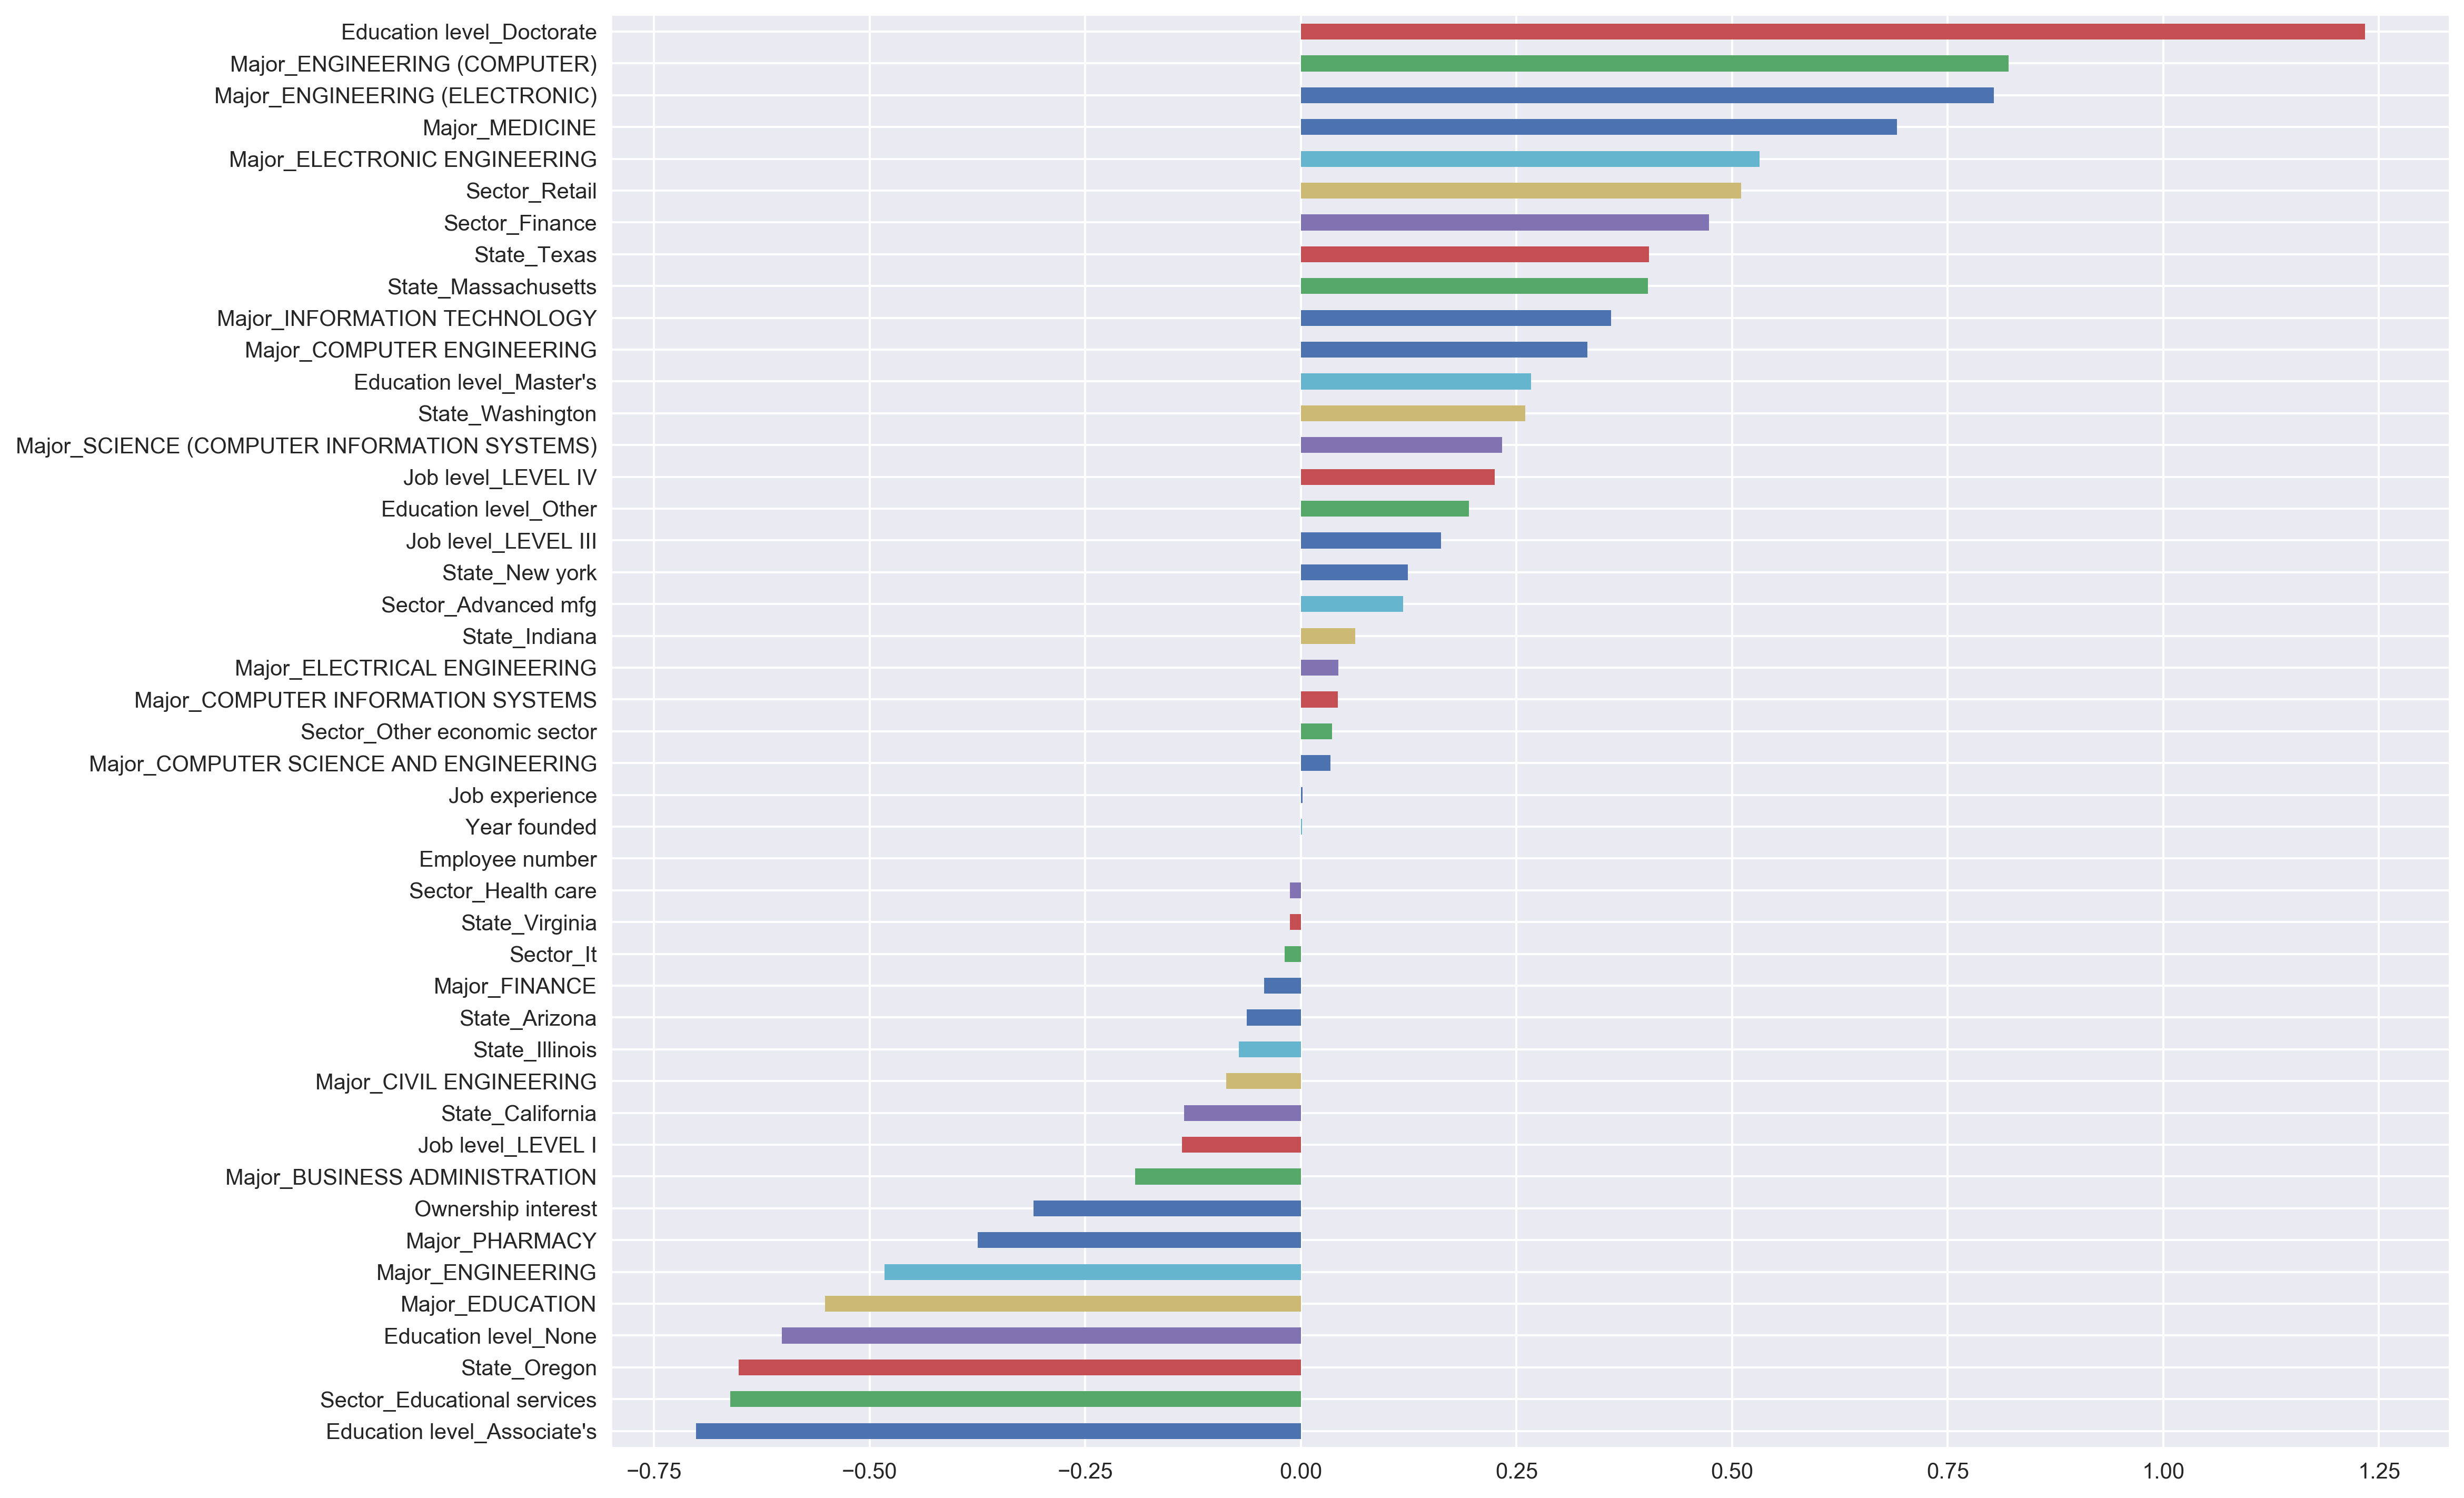

In [111]:
fig = plt.figure(figsize = (15,12))
ax = plt.subplot(111)
feature_weights[feature_weights.sort_values() != 0].sort_values().plot(kind = 'barh', ax = ax)

In [108]:
feature_weights[feature_weights.sort_values() != 0]

Ownership interest                             -3.100275e-01
Job experience                                  1.875480e-03
Year founded                                    1.472991e-03
Employee number                                -7.669871e-08
Sector_Advanced mfg                             1.187299e-01
Sector_Educational services                    -6.618599e-01
Sector_Finance                                  4.733924e-01
Sector_Health care                             -1.287067e-02
Sector_It                                      -1.887052e-02
Sector_Other economic sector                    3.610121e-02
Sector_Retail                                   5.106824e-01
Job level_LEVEL I                              -1.377772e-01
Job level_LEVEL III                             1.622150e-01
Job level_LEVEL IV                              2.246161e-01
State_Arizona                                  -6.284341e-02
State_California                               -1.352664e-01
State_Illinois          